# 2017 Ionomics Analysis Pipeline

This notebook contains the analysis of the ionomics data for the first year of Aim 1 of the NSF/PGRP project "Adapting Perennial Crops for Climate Change: Graft Transmissible Effects of Rootstocks on Grapevine Shoots" (1546869). The manuscript(s) associated with the data can be found in the README of this GitHIb repository. 

This code is provided for reproducability and as a backbone for future ionomics analysis. 

Questions about this code and project can be directed to Zachary N. Harris or Allison J. Miller. 

## Comments by various people

In [1]:
#Editing of code for SLU symposium by Zoë
# Additional edits by Zach for 2017 manuscript

### Greg notes on 05/22/17 dataset:
# All of the elements look to have quantified pretty well with the exception of sulfur and selenium. 
# Sulfur was probably a little less bad then selenium. Selenium should probably be discarded. 
# Sulfur has a scattering of samples that had very low concentrations and were noisy (you'll see the negative values), 
# but a number of the samples had a lot of sulfur and look to have measured better. 
# Our controls for sulfur were also fairly stable, which give me confidence it is overall ok.

###Greg notes on 07/30/17 and 09/25/17 datasets (received at the same time):
#The data for these looks really good, similar to the run from last summer.

## Niyati found a few lines of metadata wrong. Corrects in file '2017_ionomics_metadata_NSBedit.csv'

## Entire for dataset for Phenology=Veraison got corrupted. File 2017_ionomics_juliaFixed.csv was rebuilt from raw

## Set up workspace

In [1]:
library('tidyverse') ## Some functions get masked here. So it is worth being explicit for gather, select
library('rebus')
library('viridis')
library('dplyr') ## ## Some functions get masked here. So it is worth being explicit for gather, select
library('tibble')
library('anomalize')
library('car')
library('corrplot')
library('randomForest')
library('MASS')
library('caret')

rs_palette <- c("gray", "#1b9e77", "#7570b3", "#e6ab02")
p_palette <- c('orchid1', 'purple1', 'darkorchid4')
i_palette <- c('grey', 'lightblue', 'darkblue')
t_palette <- c('darkgreen', 'mediumpurple4')
b_palette <- c('#ffd4a3', '#ffaa5e', '#d08159')
y_palette <- c('dodgerblue4', 'springgreen1')
r_palette <- viridisLite::viridis(9)
l_palette <- c(rgb(145,102,189,maxColorValue=255),rgb(178,76,76,maxColorValue=255),rgb(0,146,146,maxColorValue=255),rgb(255,182,119,maxColorValue=255))


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  3.0.0     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘rebus’

The following object is masked from ‘package:stringr’:

    regex

The following object is masked from ‘package:ggplot2’:

    alpha

Loading required package: viridisLite
══ Use anomalize to improve your Forecasts by 50%! ═════════════════════════════
Business Science offers a 1-hour course - Lab #18: Time Series Anomaly Detection!
</> Learn more at: https://university.business-science.io/p/learning-labs-pro </>
Loading required package: carData

Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode

The following object is masked from ‘package

## Data Cleaning
JEP compiled all data from raw files given by the Baxter Lab. Metadata were associated with a python script that parsed through contructed sample names based on year, phenology, row, cell, replicate, and leaf position. A dictionary to link Cell+Replicate IDs to Rootstocks and Blocks, and Row numbers were used to attach irrigation treatments. Year and Phenology treatments were deduced from file names. 

In [2]:
data <- read.csv('2017_ionomics_juliaFixed.csv')
data$irrigation <- data$treatment
head(data)

X,samplename,year,phenology,row,replicate,cell,leafpos,treatment,block,...,Ni,Cu,Zn,As,Se,Rb,Sr,Mo,Cd,irrigation
1,2017_anthesis_8_E_1_Y,2017,Anthesis,8,1,E,Y,None,4,...,0.77143369,10.747744,19.30181,0.01133777,0.009937403,11.522449,9.661253,0.08400322,0.024697238,None
2,2017_harvest_11_B_2_Y,2017,Harvest,11,2,B,Y,RDI,2,...,0.03997534,5.113214,17.17969,0.01200985,0.013811064,6.246615,20.044803,0.15022273,0.025295544,RDI
3,2017_veraison_14_B_2_Y,2017,Veraison,14,2,B,Y,RDI,3,...,1.57125600,5.315436,11.95915,0.02407721,0.022184104,4.463661,66.194720,0.17901887,0.003469065,RDI
7,2017_anthesis_10_F_4_Z,2017,Anthesis,10,4,F,Z,Full,4,...,1.06607950,5.224421,29.91493,0.02381154,0.044536917,3.612188,82.737953,0.27983246,0.027167219,Full
8,2017_harvest_14_E_1_X,2017,Harvest,14,1,E,X,RDI,6,...,0.04640472,35.052891,17.73761,0.01355793,0.013667908,6.966490,35.942172,0.17696249,0.038010029,RDI
9,2017_veraison_10_B_1_Z,2017,Veraison,10,1,B,Z,Full,1,...,1.28312238,5.454629,15.85992,0.02798158,0.056292285,4.478028,50.201681,0.31560113,0.016191926,Full


In [3]:
# check for general evenness
table(data$rootstock)

table(data$irrigation)

table(data$leaf)

table(data$row)

table(data$phenology)

table(data$row)

table(data$block)


   1103P    3309C      SO4 Ugrafted 
     641      642      641      641 


Full None  RDI 
 850  855  860 


  X   Y   Z 
859 852 854 


  8   9  10  11  12  13  14  15  16 
284 287 282 288 285 284 285 287 283 


Anthesis  Harvest Veraison 
     853      862      850 


  8   9  10  11  12  13  14  15  16 
284 287 282 288 285 284 285 287 283 


  1   2   3   4   5   6 
424 428 426 429 429 429 

In [4]:
## Finally, let's refactor the columns to clean up the rest of this beast

data$rootstock <- factor(data$rootstock, levels=c('Ugrafted', '1103P', '3309C', 'SO4'), labels=c('Ungrafted', '1103P', '3309C', 'SO4'))
data$irrigation <- factor(data$irrigation, levels=c('None', 'RDI', 'Full'))
data$phenology <- factor(data$phenology, levels=c('Anthesis', 'Veraison', 'Harvest'))
data$row <- as.factor(data$row)
data$block <- as.factor(data$block)

In [5]:
# check refactoring

table(data$rootstock)

table(data$irrigation)

table(data$leaf)

table(data$row)

table(data$phenology)

table(data$row)

table(data$block)


Ungrafted     1103P     3309C       SO4 
      641       641       642       641 


None  RDI Full 
 855  860  850 


  X   Y   Z 
859 852 854 


  8   9  10  11  12  13  14  15  16 
284 287 282 288 285 284 285 287 283 


Anthesis Veraison  Harvest 
     853      850      862 


  8   9  10  11  12  13  14  15  16 
284 287 282 288 285 284 285 287 283 


  1   2   3   4   5   6 
424 428 426 429 429 429 

In [ ]:
# Finally, ion concentrations shouldn't be negative. All negatives are set to zero. 

In [6]:
colnames(data)

[1] "X"          "samplename" "year"       "phenology"  "row"       
 [6] "replicate"  "cell"       "leafpos"    "treatment"  "block"     
[11] "rootstock"  "B"          "Na"         "Mg"         "Al"        
[16] "P"          "S"          "K"          "Ca"         "Fe"        
[21] "Mn"         "Co"         "Ni"         "Cu"         "Zn"        
[26] "As"         "Se"         "Rb"         "Sr"         "Mo"        
[31] "Cd"         "irrigation"

In [7]:
data$B[data$B < 0] <- 0
data$Na[data$Na < 0] <- 0 
data$Mg[data$Mg < 0] <- 0 
data$Al[data$Al < 0] <- 0 
data$P[data$P < 0] <- 0
data$S[data$S < 0] <- 0
data$K[data$K < 0] <- 0
data$Ca[data$Ca < 0] <- 0 
data$Fe[data$Fe < 0] <- 0 
data$Mn[data$Mn < 0] <- 0 
data$Co[data$Co < 0] <- 0 
data$Ni[data$Ni < 0] <- 0 
data$Cu[data$Cu < 0] <- 0 
data$Zn[data$Zn < 0] <- 0 
data$As[data$As < 0] <- 0 
data$Se[data$Se < 0] <- 0 
data$Rb[data$Rb < 0] <- 0 
data$Sr[data$Sr < 0] <- 0 
data$Mo[data$Mo < 0] <- 0 
data$Cd[data$Cd < 0] <- 0

In [8]:
# show summary of data
data %>% dplyr::select(B:Cd) %>% summary()

       B                 Na               Mg              Al        
 Min.   :   0.00   Min.   :  0.00   Min.   :    0   Min.   : 0.000  
 1st Qu.:  14.89   1st Qu.: 12.04   1st Qu.: 1887   1st Qu.: 6.729  
 Median :  18.70   Median : 18.88   Median : 2292   Median :11.415  
 Mean   :  23.13   Mean   : 34.32   Mean   : 2399   Mean   :14.233  
 3rd Qu.:  28.15   3rd Qu.: 33.44   3rd Qu.: 2802   3rd Qu.:19.859  
 Max.   :1169.83   Max.   :644.09   Max.   :13036   Max.   :99.879  
       P               S                   K               Ca       
 Min.   :    0   Min.   :      0.0   Min.   :    0   Min.   :    0  
 1st Qu.: 1787   1st Qu.:    634.1   1st Qu.: 6483   1st Qu.: 8551  
 Median : 2583   Median :   1268.9   Median : 8357   Median :11215  
 Mean   : 2948   Mean   :   1810.2   Mean   : 9517   Mean   :12958  
 3rd Qu.: 3547   3rd Qu.:   1852.0   3rd Qu.:12209   3rd Qu.:16232  
 Max.   :22743   Max.   :1043540.4   Max.   :29435   Max.   :49504  
       Fe               Mn        

## Networks for broad description

Here, I play with some network visualizations to vizualize the modularity of the ionome over the course of the growing season, over vine development, and across rootstocks. Some of these become the basis for the supplemental figure for ionomics. 

In [10]:
library('igraph')


Attaching package: ‘igraph’

The following objects are masked from ‘package:rebus’:

    %c%, graph

The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union

The following objects are masked from ‘package:purrr’:

    compose, simplify

The following object is masked from ‘package:tidyr’:

    crossing

The following object is masked from ‘package:tibble’:

    as_data_frame

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



First, I want to remove any data points that are more than 5 sd from the mean. This is a pretty sloppy way to do it on 20 columns, but alas...

In [11]:
is_gt <- function(dist, threshold){
    samples <- rownames(d)[dist > threshold | dist < -threshold]
    return(samples)
}


d <- data %>% dplyr::select(B:Cd)
rownames(d) <- data$samplename
d <- as.data.frame(scale(d, scale=T, center=T))
x <- apply(d, 2, is_gt, threshold=2.5)
outliers <- unique(unlist(x))
data_clean <- data[!(data$samplename %in% outliers),]
d_clean <- data_clean %>% dplyr::select(B:Cd)
d_cleanScale <- scale(d_clean, scale=T, center=T)

dim(d_clean)
dim(d_cleanScale)

[1] 2009   20

[1] 2009   20

Below, I steal a function from JEP to make the networks easier to construct. If an ion contains NAs after subsetting (only important after 2017), then it drops that ion for that network. Otherwise, everything is included. 

In [12]:
containNA <- function(vec){
    if (sum(is.na(vec)) > 0){
        return(1)
    } else {
        return(0)
    }
}

make_network_diagram <- function(d, factor_vector=NA) {
    if (any(is.na(factor_vector))){
        factor_vector = factor(rep(1, dim(d)[1]))
        levels <- levels(factor_vector)   
    } else {
        levels <- levels(factor_vector)
    }
    
    for (f in levels){
        x <- d[factor_vector == f,]
        filt_vec <- apply(x, 2, containNA)
        x <- x[,!filt_vec]
        x <- cor(x)
        res1 <- cor.mtest(x, conf.level = .95)
        colnames(res1$p) <- colnames(x)
        rownames(res1$p) <- rownames(x)
        pmat.adj <- res1$p %>% as.vector() %>% p.adjust(method='fdr') %>% matrix(ncol=dim(x)[2])
        colnames(pmat.adj) <- colnames(x)
        rownames(pmat.adj) <- rownames(x) 
        screen_mat <- pmat.adj
        screen_mat[screen_mat > 0.05] <- 0
        x[screen_mat == 0] <- 0
        g_raw <- graph_from_adjacency_matrix(x, mode='upper', weighted=T, diag=F)
        g <- graph_from_adjacency_matrix(abs(x)^2, mode='upper', weighted=T, diag=F)
        E(g)$color[E(g_raw)$weight > 0] <- 'skyblue1'
        E(g)$color[E(g_raw)$weight < 0] <- 'salmon1'
        plot(g, layout=layout.auto, edge.width=abs(E(g)$weight)*16, vertex.color='white', main=f)
    }
}

In [54]:
pdf('2017_ionomics_correlations_phenology_autoNetworkLayout.pdf', width=11, height=11, onefile=T)
  make_network_diagram(d_cleanScale, data_clean$phenology)
dev.off()

pdf('2017_ionomics_correlations_leafpos_autoNetworkLayout.pdf', width=11, height=11, onefile=T)
  make_network_diagram(d_cleanScale, data_clean$leafpos)
dev.off()

pdf('2017_ionomics_correlations_rootstock_autoNetworkLayout.pdf', width=11, height=11, onefile=T)
  make_network_diagram(d_cleanScale, data_clean$rootstock)
dev.off()

pdf('2017_ionomics_correlations_block_autoNetworkLayout.pdf', width=11, height=11, onefile=T)
  make_network_diagram(d_cleanScale, data_clean$block)
dev.off()

pdf('2017_ionomics_correlations_irrigation_autoNetworkLayout.pdf', width=11, height=11, onefile=T)
  make_network_diagram(d_cleanScale, data_clean$irrigation)
dev.off()

pdf 
  2

pdf 
  2

pdf 
  2

pdf 
  2

pdf 
  2

## PCA

The only method that I actually care about (just kidding). 

In [13]:
d <- data %>% dplyr::select(B:Cd)
rownames(d) <- data$samplename
d <- as.data.frame(scale(d, scale=T, center=T))
x <- apply(d, 2, is_gt, threshold=5)
outliers <- unique(unlist(x))
data_clean <- data[!(data$samplename %in% outliers),]
d_clean <- data_clean %>% dplyr::select(B:Cd)
d_cleanScale <- scale(d_clean, scale=T, center=T)

pca <- prcomp(d_cleanScale)
x <- summary(pca)

In [14]:
x

Importance of components:
                          PC1    PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     2.3032 2.1909 1.30360 1.04767 1.00612 0.93728 0.86527
Proportion of Variance 0.2652 0.2400 0.08497 0.05488 0.05061 0.04392 0.03743
Cumulative Proportion  0.2652 0.5052 0.59021 0.64509 0.69570 0.73963 0.77706
                           PC8     PC9    PC10    PC11    PC12   PC13    PC14
Standard deviation     0.81745 0.80466 0.73392 0.65148 0.64379 0.6149 0.54560
Proportion of Variance 0.03341 0.03237 0.02693 0.02122 0.02072 0.0189 0.01488
Cumulative Proportion  0.81047 0.84285 0.86978 0.89100 0.91172 0.9306 0.94551
                          PC15   PC16    PC17    PC18    PC19    PC20
Standard deviation     0.52448 0.5176 0.44521 0.40153 0.36093 0.23895
Proportion of Variance 0.01375 0.0134 0.00991 0.00806 0.00651 0.00285
Cumulative Proportion  0.95926 0.9727 0.98257 0.99063 0.99715 1.00000

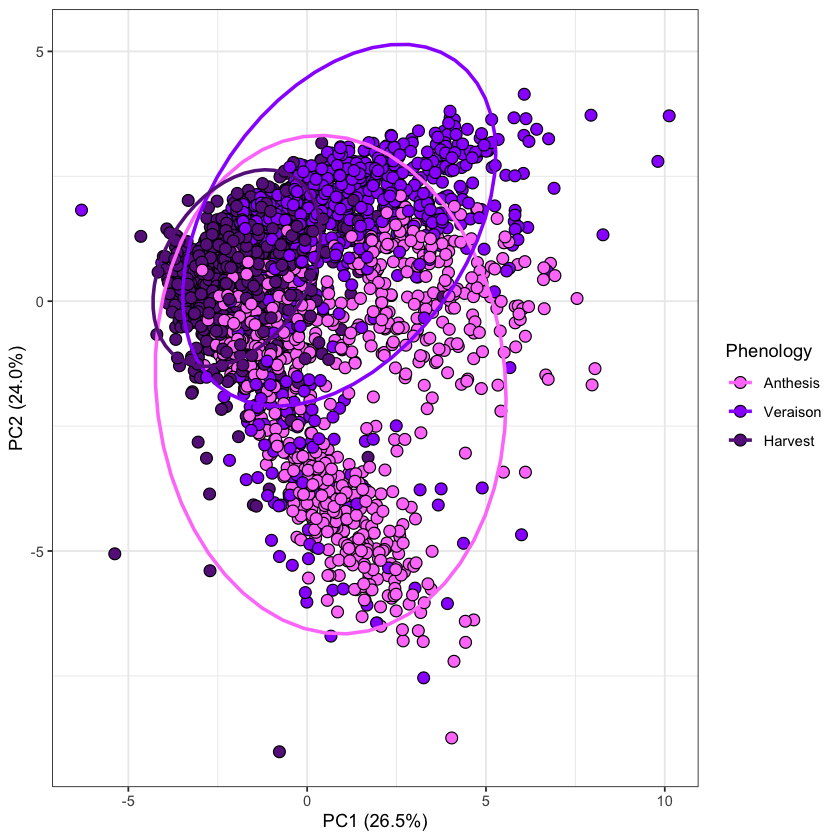

pdf 
  2

pdf 
  2

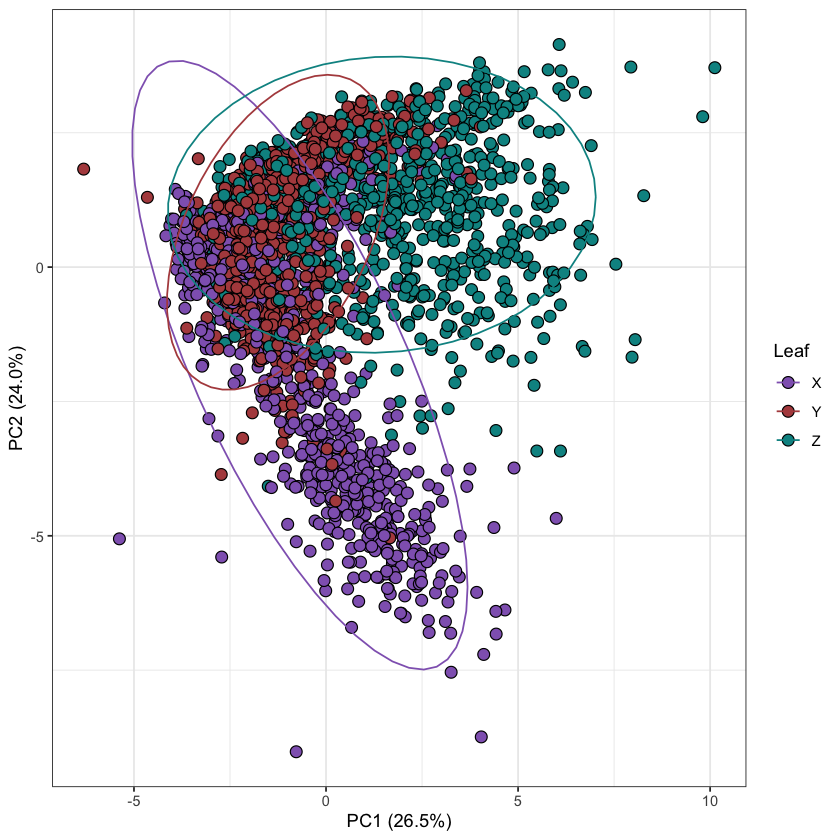

In [15]:
d <- as.data.frame(pca$x) %>% dplyr::select(PC1:PC2)
d$sampleName <- data_clean$sampleName
d$Phenology <- data_clean$phenology
d$Irrigation <- data_clean$irrigation
d$Leaf <- data_clean$leaf
d$Rootstock <- data_clean$rootstock

PCA.phenology <- ggplot(d, aes(x=PC1, y=PC2, fill=Phenology, shape=Phenology)) +
  geom_point(size=3) +
  scale_shape_manual(values=c(21, 21, 21)) +
  scale_fill_manual(values=p_palette) +
  stat_ellipse(aes(color=Phenology), linetype=1, size=1) + 
  scale_color_manual(values=p_palette) + 
  xlab("PC1 (26.5%)") + ylab("PC2 (24.0%)") + 
  theme_bw()
PCA.phenology

PCA.leaf_position <- ggplot(d, aes(x=PC1, y=PC2, fill=Leaf, shape=Leaf)) +
  geom_point(size=3) +
  scale_shape_manual(values=c(21, 21, 21)) +
  scale_fill_manual(values=l_palette) +
  stat_ellipse(aes(color=Leaf)) + 
  scale_color_manual(values=l_palette) + 
  xlab("PC1 (26.5%)") + ylab("PC2 (24.0%)") + 
  theme_bw()
PCA.leaf_position

pdf('2017_ionomics_pca_scaled_phenology.pdf')
  PCA.phenology
dev.off()

pdf('2017_ionomics_pca_scaled_leafPosition.pdf')
  PCA.leaf_position
dev.off()


From above, It looks like both PC1 and PC2 are controlled by Phenology X Leaf Position interactions. Plot for verification. 

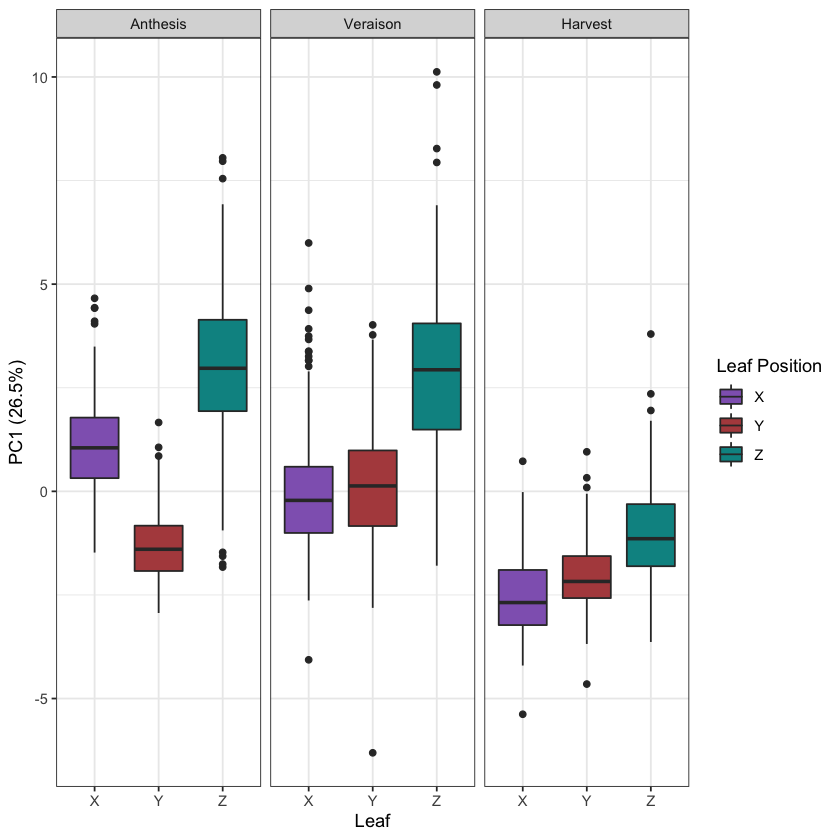

pdf 
  2

pdf 
  2

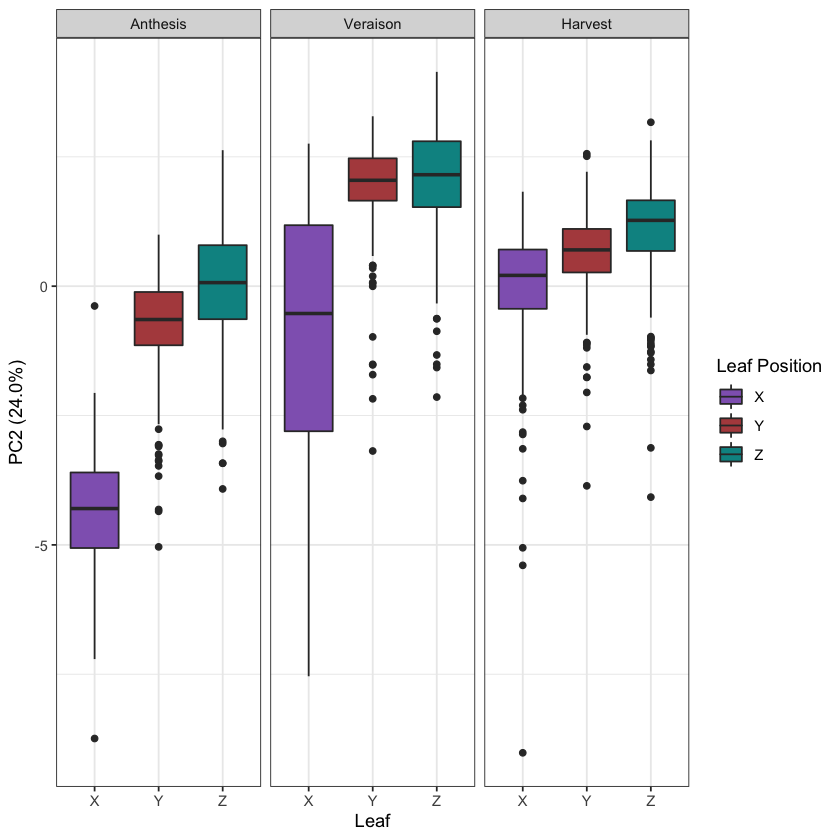

In [16]:
PC1.leafPositionByPhenology <- ggplot(d, aes(x=Leaf, y=PC1, fill=Leaf)) + 
  geom_boxplot() + 
  facet_wrap('Phenology') +
  scale_fill_manual("Leaf Position", values=l_palette) + 
  ylab("PC1 (26.5%)") + 
  theme_bw()

PC2.leafPositionByPhenology <- ggplot(d, aes(x=Leaf, y=PC2, fill=Leaf)) + 
  geom_boxplot() + 
  facet_wrap('Phenology') +
  scale_fill_manual("Leaf Position", values=l_palette) + 
  ylab("PC2 (24.0%)") + 
  theme_bw()

PC1.leafPositionByPhenology
PC2.leafPositionByPhenology

pdf('2017_ionomics_pcaBoxPlot_PC1.pdf')
  PC1.leafPositionByPhenology
dev.off()

pdf('2017_ionomics_pcaBoxPlot_PC2.pdf')
  PC2.leafPositionByPhenology
dev.off()


## Outlier detection/removal and lm fitting

In this section, I fit a linear model to each of the 20 ions independently. The loop contains comments for each sections of code including data extraction, outpier removal, linear model fitting, and Anova computations on the linear models. LMs and Anova outputs are stores to lists for future use if needed. 

In [17]:
#from Zoe:
#this is how i removed outliers for the 2014/2016 paper. 
#But it's important to look at the distirbutions of each ion, 
#the old machine that was used in 2014 had some pretty noisy data, 
# while the 2016 machine (which would have been used for these samples) was pretty good, 
# so outlier removal might not be necessary at all. 

# from Zach:
# I pretty significantly edited this section to look at outliers 
# First, I explicitly plot each element, then I filter using dplyr's anomalize
# Then I fit the lm and compute the stats using a type-3 SS (assuming interactions will be important)
# I also touched up a for efficiency :)

# Create a variable/vector/collection of the column names you want to remove outliers on.
vars <- c("B", "Na", "Mg", "Al", "P", "S", "K", "Ca", "Fe", "Mn", "Co", "Ni", "Cu", "Zn", "As", "Se", "Rb", "Sr", "Mo", "Cd")

# create a collector for models and anovas
models <- list(rep(0, length(vars)))
anovas <- list(rep(0, length(vars)))

pdf('element_distributions_scaled.pdf', onefile=TRUE)

# set the appropriate contrasts for type3 SS

oldc <- getOption("contrasts")
options(contrasts=c('contr.sum','contr.poly'))


for (idx in 1:length(vars)){
    # get element name at index
    element_id <- vars[idx]
    
    #extract data, plot dist
    d <- data[,c('samplename', 'row', 'irrigation', 'leafpos', 'rootstock', 'phenology', 'block')]
    d$element <- data[,element_id]
    d_norm <- as.vector(scale(d$element, scale=TRUE, center=TRUE))
    d$element <- d_norm
    p <- ggplot(d, aes(element)) + geom_density() + geom_rug() + ggtitle(paste(element_id, 'raw', sep='_'))
    print(p)
    
    # remove outliers, replot, fix colnames
    d <- anomalize(as_tibble(d), target=element, method='iqr', alpha=0.03, max_anoms=0.1)
    d <- d[d$anomaly != 'Yes',]
    p <- ggplot(d, aes(element)) + geom_density() + geom_rug() + ggtitle(paste(element_id, 'clean', sep='_'))
    print(p)
    colnames(d) <- c('sample', 'Row', 'Irrigation', 'Leaf_index', 'Rootstock', 'Phenology', 'Block', 'element', 'e1', 'e2', 'anomaly')

    # fit lms
    model <- lm(element ~ Block + Irrigation + Leaf_index + Rootstock + Phenology + Leaf_index:Rootstock + Leaf_index:Phenology + Rootstock:Phenology, data=d, singular.ok=TRUE)
    models[[idx]] <- model
    
    # compute stats on model under type-3 SS
    stats <- car::Anova(model, type=3)
    anovas[[idx]] <- stats
    
}
dev.off()

# reset base contrasts so nothing is too broken
options(contrasts = oldc)

pdf 
  2

## Model interpretation

This entire section is spiritually guided by Zoe's old code, but I reformated it to work with the models as I generated. In short, it computes the variation explained by each term in the model (eta squared), then does some reformating and table generation to get it into a form that ggplot can use for a tile plot. The final plot is printed to a large file so names don't overrun, but it is teased here as well. 

In [18]:
factors <- rownames(anovas[[1]])[2:length(rownames(anovas[[1]]))]

total_var_mat_p=matrix(,length(vars),length(factors)*2)
colnames(total_var_mat_p) <- c(factors, paste(factors, 'p', sep='_'))
rownames(total_var_mat_p) <- vars

for (idx in 1:length(vars)){
    range <- 2:(length(factors)+1)
    SS <- anovas[[idx]]$Sum[range]
    total_var <- sum(SS, na.rm=TRUE)
    var_exp <- SS/total_var * 100
    var_p <- anovas[[idx]]$Pr[range]
    mat_row <- c(var_exp, var_p)
    total_var_mat_p[idx,] <- mat_row
}

head(total_var_mat_p)

,Block,Irrigation,Leaf_index,Rootstock,Phenology,Leaf_index:Rootstock,Leaf_index:Phenology,Rootstock:Phenology,Residuals,Block_p,Irrigation_p,Leaf_index_p,Rootstock_p,Phenology_p,Leaf_index:Rootstock_p,Leaf_index:Phenology_p,Rootstock:Phenology_p,Residuals_p
B,0.4528727,0.31193680,9.175777,1.43221380,42.005831,0.02598155,4.899500,0.08487926,41.61101,9.800517e-04,0.0008353643,7.433239e-83,1.129766e-14,2.354234e-288,8.805049e-01,1.339153e-44,4.239292e-01,NA
Na,0.2728054,0.43244013,27.248871,0.07947254,10.937419,0.07964548,10.685979,0.08106161,50.18231,7.772878e-02,0.0003943567,8.479031e-173,2.356178e-01,5.974247e-79,5.748741e-01,4.164645e-75,5.661492e-01,NA
Mg,0.9565365,0.04596329,1.680689,7.67887037,27.398504,1.50528913,7.267687,0.41409970,53.05236,2.464201e-06,0.4398147049,1.421121e-13,2.070426e-56,3.065788e-172,8.108135e-11,1.500651e-51,5.232005e-03,NA
Al,0.1591832,0.02379664,15.810163,0.04562851,31.758280,0.09031353,10.415444,0.12427474,41.57292,2.023216e-01,0.5811345825,1.718973e-133,3.532925e-01,1.641929e-234,3.901712e-01,1.534222e-90,2.255801e-01,NA
P,0.4562166,0.17984626,8.410921,2.84870280,49.260244,1.22778215,3.169880,1.21220620,33.23420,9.629293e-05,0.0060472100,1.832195e-93,1.565236e-34,0.000000e+00,4.250728e-14,2.972582e-36,6.443182e-14,NA
S,1.2985983,0.44757246,28.654175,5.71411021,4.490184,0.96937172,2.636798,1.19980260,54.58939,1.880713e-08,0.0004473005,8.462807e-174,1.462921e-41,3.768336e-33,1.053096e-06,1.990564e-18,2.575250e-08,NA


In [19]:
total_var_mat_p <- data.frame(total_var_mat_p)

total_var_mat_p$element <- rownames(total_var_mat_p)
total_var_mat_p$Residuals <- NULL
total_var_mat_p$Residuals_p <- NULL

head(total_var_mat_p)

write.csv(total_var_mat_p, file='2017_ionomics_var_p_norm.csv', quote=F)

,Block,Irrigation,Leaf_index,Rootstock,Phenology,Leaf_index.Rootstock,Leaf_index.Phenology,Rootstock.Phenology,Block_p,Irrigation_p,Leaf_index_p,Rootstock_p,Phenology_p,Leaf_index.Rootstock_p,Leaf_index.Phenology_p,Rootstock.Phenology_p,element
B,0.4528727,0.31193680,9.175777,1.43221380,42.005831,0.02598155,4.899500,0.08487926,9.800517e-04,0.0008353643,7.433239e-83,1.129766e-14,2.354234e-288,8.805049e-01,1.339153e-44,4.239292e-01,B
Na,0.2728054,0.43244013,27.248871,0.07947254,10.937419,0.07964548,10.685979,0.08106161,7.772878e-02,0.0003943567,8.479031e-173,2.356178e-01,5.974247e-79,5.748741e-01,4.164645e-75,5.661492e-01,Na
Mg,0.9565365,0.04596329,1.680689,7.67887037,27.398504,1.50528913,7.267687,0.41409970,2.464201e-06,0.4398147049,1.421121e-13,2.070426e-56,3.065788e-172,8.108135e-11,1.500651e-51,5.232005e-03,Mg
Al,0.1591832,0.02379664,15.810163,0.04562851,31.758280,0.09031353,10.415444,0.12427474,2.023216e-01,0.5811345825,1.718973e-133,3.532925e-01,1.641929e-234,3.901712e-01,1.534222e-90,2.255801e-01,Al
P,0.4562166,0.17984626,8.410921,2.84870280,49.260244,1.22778215,3.169880,1.21220620,9.629293e-05,0.0060472100,1.832195e-93,1.565236e-34,0.000000e+00,4.250728e-14,2.972582e-36,6.443182e-14,P
S,1.2985983,0.44757246,28.654175,5.71411021,4.490184,0.96937172,2.636798,1.19980260,1.880713e-08,0.0004473005,8.462807e-174,1.462921e-41,3.768336e-33,1.053096e-06,1.990564e-18,2.575250e-08,S


In [20]:
# Get variance columns
total_var <- total_var_mat_p %>% dplyr::select(element, Block:Rootstock.Phenology)

# reorganize and rename to format for plotting
total_var <- total_var %>% gather(key=factor, value=var, -element)

total_var <- total_var %>% mutate(factor=str_replace(factor, "_var" %R% END, ""))
head(total_var)

element,factor,var
B,Block,0.4528727
Na,Block,0.2728054
Mg,Block,0.9565365
Al,Block,0.1591832
P,Block,0.4562166
S,Block,1.2985983


In [21]:
#get p-value columns
total_p <- total_var_mat_p %>% dplyr::select(Block_p:Rootstock.Phenology_p)
total_p <- data.frame(t(apply(total_p, 1, FUN=p.adjust, method='fdr')))
total_p$element <- total_var_mat_p$element

#reorganize and rename to format for plotting
total_p <- total_p %>% gather(key=factor, value=p_value, -element)
total_p <- total_p %>% mutate(factor=str_replace(factor,"_p" %R% END, ""))

#join variance and p-value tables back together 
total_var_p <- full_join(total_var, total_p,by=c("element", "factor"))

pdf 
  2

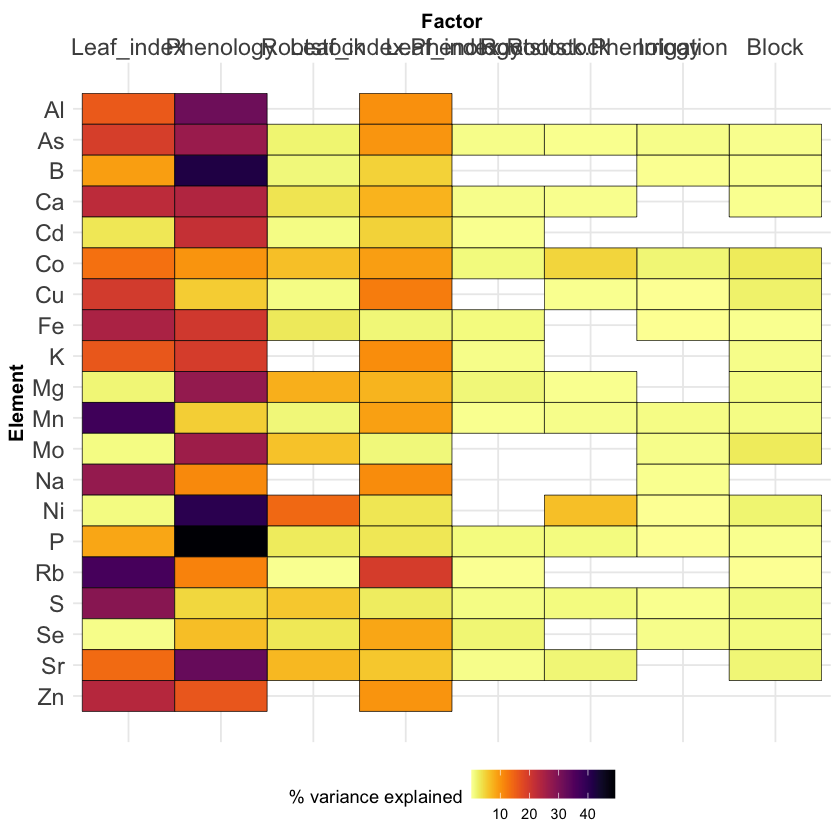

In [22]:
#elements need a number for y-axis when plotting, there are 20 elements here 
total_var_p <- total_var_p %>% arrange(element) %>% mutate(element_number=rep(1:20, each=8))

#only plot significant p_values
total_var_p_sig <- total_var_p %>% filter(p_value < 0.05) 
write.table(total_var_p_sig[,c("element", "factor","var", "p_value")], "2017_ionomics_var_p_sig.txt", sep="\t", row.names=F, quote=F, col.names=T)

#make plot
total_var_p_sig$factor <- factor(total_var_p_sig$factor, levels=c('Leaf_index', 'Phenology', 'Rootstock', 'Leaf_index.Phenology', 'Leaf_index.Rootstock', 'Rootstock.Phenology', 'Irrigation', 'Block'))

t <- ggplot(data=total_var_p_sig, aes(x=factor, y=as.numeric(as.character(element_number)), fill=var)) + 
    geom_tile(color="black", size=0.2)+
    theme_minimal() +
    labs(x = "Factor", y="Element") + 
    theme(axis.text=element_text(size=14),axis.title=element_text(size=12,face="bold"),legend.position = "bottom") +
    scale_y_continuous(trans="reverse", breaks = seq(1, 20, 1), minor_breaks=NULL, labels=unique(total_var_p_sig[,"element"])) +
    scale_x_discrete(position = "top") +
    scale_fill_viridis(option="inferno", name="% variance explained", direction = -1)

t

pdf("ionomic_variance_heatmap_black_viridis_norm2.pdf", width=14, height=8)
  t
dev.off()

## Compute post-hocs on the ions presented in manuscript

In the manuscript, I pull out some ions to highlight in both the figures and the manuscript test. This section simply re-extracts the data, recalls the LMs from memory, and computes post-hoc comparisons of means for the terms highlighted in the section headings. 

In [23]:
library('emmeans')

#### Calcium and Potassium for Leaf position by Phenology
check to see if emmeans reports interation by commas or spaces: will change the needed reshape::colsplit commands

In [25]:
# get element name, model, and anova 
element_id <- 'Ca'
model <- models[[which(vars == element_id)]]
anova <- anovas[[which(vars == element_id)]]

#re-normalize so d points to appropriate data
d <- data[,c('samplename', 'row', 'irrigation', 'leafpos', 'rootstock', 'phenology', 'block')]
d$element <- data[,element_id]
d_norm <- as.vector(scale(d$element, scale=TRUE, center=TRUE))
d$element <- d_norm
d <- anomalize(as_tibble(d), target=element, method='iqr', alpha=0.03, max_anoms=0.1)
d <- d[d$anomaly != 'Yes',]
colnames(d) <- c('samplename', 'Row', 'Irrigation', 'Leaf_index', 'Rootstock', 'Phenology', 'Block', 'element', 'e1', 'e2', 'anomaly')

# pval cutoff for the post-hoc
p.val.max <- 0.05/4

module.emm <- emmeans::emmeans(model, ~Leaf_index:Phenology)
res <- as.data.frame(pairs(module.emm))
res <- transform(res, comps=reshape::colsplit(contrast, split = "-", names = c('c1', 'c2')))
res <- transform(res, c1=reshape::colsplit(comps.c1, split = ",", names = c('i1', 'p1')))
res <- transform(res, c2=reshape::colsplit(comps.c2, split = ",", names = c('i2', 'p2')))
res$c2.p2 <- trimws(res$c2.p2, which='left')
res$c1.p1 <- trimws(res$c1.p1, which='right')
res <- res[res$c1.p1 == res$c2.p2,] %>% dplyr::select(contrast:p.value)
res$p.adj <- p.adjust(res$p.value, method='fdr')
res <- res[res$p.adj < p.val.max,]
res

,contrast,estimate,SE,df,t.ratio,p.value,p.adj
1,"X,Anthesis - Y,Anthesis",0.5408293,0.06489315,1898,8.334152,2.545331e-11,4.572742e-11
2,"X,Anthesis - Z,Anthesis",-1.4297000,0.06481447,1898,-22.058347,2.535216e-11,4.572742e-11
9,"Y,Anthesis - Z,Anthesis",-1.9705293,0.06511979,1898,-30.260068,2.535216e-11,4.572742e-11
23,"X,Veraison - Z,Veraison",-1.1245572,0.06488905,1898,-17.330462,2.535216e-11,4.572742e-11
27,"Y,Veraison - Z,Veraison",-0.9535973,0.06481283,1898,-14.713095,2.535216e-11,4.572742e-11
35,"X,Harvest - Z,Harvest",-0.4805967,0.06450971,1898,-7.449989,3.048495e-11,4.572742e-11
36,"Y,Harvest - Z,Harvest",-0.3297978,0.06450971,1898,-5.112374,1.239565e-05,1.593727e-05


In [26]:
# get element name, model, and anova 
element_id <- 'K'
model <- models[[which(vars == element_id)]]
anova <- anovas[[which(vars == element_id)]]

#re-normalize so d points to appropriate data
d <- data[,c('samplename', 'row', 'irrigation', 'leafpos', 'rootstock', 'phenology', 'block')]
d$element <- data[,element_id]
d_norm <- as.vector(scale(d$element, scale=TRUE, center=TRUE))
d$element <- d_norm
d <- anomalize(as_tibble(d), target=element, method='iqr', alpha=0.03, max_anoms=0.1)
d <- d[d$anomaly != 'Yes',]
colnames(d) <- c('sample', 'Row', 'Irrigation', 'Leaf_index', 'Rootstock', 'Phenology', 'Block', 'element', 'e1', 'e2', 'anomaly')

# pval cutoff for the post-hoc
p.val.max <- 0.05/4

module.emm <- emmeans::emmeans(model, ~Leaf_index:Phenology)
res <- as.data.frame(pairs(module.emm))
res <- transform(res, comps=reshape::colsplit(contrast, split = "-", names = c('c1', 'c2')))
res <- transform(res, c1=reshape::colsplit(comps.c1, split = ",", names = c('i1', 'p1')))
res <- transform(res, c2=reshape::colsplit(comps.c2, split = ",", names = c('i2', 'p2')))    
res$c2.p2 <- trimws(res$c2.p2, which='left')
res$c1.p1 <- trimws(res$c1.p1, which='right')
res <- res[res$c1.p1 == res$c2.p2,] %>% dplyr::select(contrast:p.value)
res$p.adj <- p.adjust(res$p.value, method='fdr')
res <- res[res$p.adj < p.val.max,]
res

,contrast,estimate,SE,df,t.ratio,p.value,p.adj
1,"X,Anthesis - Y,Anthesis",0.7684862,0.06986995,1898,10.99881,2.541123e-11,4.574021e-11
2,"X,Anthesis - Z,Anthesis",1.7535665,0.06978523,1898,25.12805,2.535216e-11,4.574021e-11
9,"Y,Anthesis - Z,Anthesis",0.9850803,0.07011397,1898,14.04970,2.535216e-11,4.574021e-11
22,"X,Veraison - Y,Veraison",1.1767124,0.06994852,1898,16.82255,2.535216e-11,4.574021e-11
23,"X,Veraison - Z,Veraison",1.0158836,0.06986554,1898,14.54055,2.535216e-11,4.574021e-11


#### Cobalt and Nickel for Rootstock by Phenology

In [95]:
# get element name, model, and anova 
element_id <- 'Co'
model <- models[[which(vars == element_id)]]
anova <- anovas[[which(vars == element_id)]]

#re-normalize so d points to appropriate data
d <- data[,c('samplename', 'row', 'irrigation', 'leafpos', 'rootstock', 'phenology', 'block')]
d$element <- data[,element_id]
d_norm <- as.vector(scale(d$element, scale=TRUE, center=TRUE))
d$element <- d_norm
d <- anomalize(as_tibble(d), target=element, method='iqr', alpha=0.03, max_anoms=0.1)
d <- d[d$anomaly != 'Yes',]
colnames(d) <- c('sample', 'Row', 'Irrigation', 'Leaf_index', 'Rootstock', 'Phenology', 'Block', 'element', 'e1', 'e2', 'anomaly')

# pval cutoff for the post-hoc
p.val.max <- 0.05/4

module.emm <- emmeans::emmeans(model, ~Rootstock:Phenology)
res <- as.data.frame(pairs(module.emm))
res <- transform(res, comps=reshape::colsplit(contrast, split = "-", names = c('c1', 'c2')))
res <- transform(res, c1=reshape::colsplit(comps.c1, split = ",", names = c('i1', 'p1')))
res <- transform(res, c2=reshape::colsplit(comps.c2, split = ",", names = c('i2', 'p2')))    
res$c2.p2 <- trimws(res$c2.p2, which='left')
res$c1.p1 <- trimws(res$c1.p1, which='right')
res <- res[res$c1.p1 == res$c2.p2,] %>% dplyr::select(contrast:p.value)
res$p.adj <- p.adjust(res$p.value, method='fdr')
res <- res[res$p.adj < p.val.max,]
res

,contrast,estimate,SE,df,t.ratio,p.value,p.adj
1,"Ungrafted,Anthesis - 1103P,Anthesis",-0.9029486,0.06152719,2530,-14.675604,0.000000e+00,0.000000e+00
12,"1103P,Anthesis - 3309C,Anthesis",1.0161856,0.06159921,2530,16.496730,0.000000e+00,0.000000e+00
13,"1103P,Anthesis - SO4,Anthesis",0.7848848,0.06159853,2530,12.741940,0.000000e+00,0.000000e+00
39,"Ungrafted,Veraison - 1103P,Veraison",-0.4052712,0.06188961,2530,-6.548291,4.320965e-09,1.111105e-08
41,"Ungrafted,Veraison - SO4,Veraison",-0.4691106,0.06174211,2530,-7.597904,0.000000e+00,0.000000e+00
46,"1103P,Veraison - 3309C,Veraison",0.5097059,0.06166913,2530,8.265171,0.000000e+00,0.000000e+00
52,"3309C,Veraison - SO4,Veraison",-0.5735454,0.06152321,2530,-9.322423,0.000000e+00,0.000000e+00
63,"Ungrafted,Harvest - SO4,Harvest",-0.2696589,0.06116278,2530,-4.408873,6.636657e-04,1.493248e-03
66,"3309C,Harvest - SO4,Harvest",-0.2558921,0.06116277,2530,-4.183789,1.763916e-03,3.527831e-03


In [96]:
# get element name, model, and anova 
element_id <- 'Ni'
model <- models[[which(vars == element_id)]]
anova <- anovas[[which(vars == element_id)]]

#re-normalize so d points to appropriate data
d <- data[,c('samplename', 'row', 'irrigation', 'leafpos', 'rootstock', 'phenology', 'block')]
d$element <- data[,element_id]
d_norm <- as.vector(scale(d$element, scale=TRUE, center=TRUE))
d$element <- d_norm
d <- anomalize(as_tibble(d), target=element, method='iqr', alpha=0.03, max_anoms=0.1)
d <- d[d$anomaly != 'Yes',]
colnames(d) <- c('sample', 'Row', 'Irrigation', 'Leaf_index', 'Rootstock', 'Phenology', 'Block', 'element', 'e1', 'e2', 'anomaly')

# pval cutoff for the post-hoc
p.val.max <- 0.05/4

module.emm <- emmeans::emmeans(model, ~Rootstock:Phenology)
res <- as.data.frame(pairs(module.emm))
res <- transform(res, comps=reshape::colsplit(contrast, split = "-", names = c('c1', 'c2')))
res <- transform(res, c1=reshape::colsplit(comps.c1, split = ",", names = c('i1', 'p1')))
res <- transform(res, c2=reshape::colsplit(comps.c2, split = ",", names = c('i2', 'p2')))    
res$c2.p2 <- trimws(res$c2.p2, which='left')
res$c1.p1 <- trimws(res$c1.p1, which='right')
res <- res[res$c1.p1 == res$c2.p2,] %>% dplyr::select(contrast:p.value)
res$p.adj <- p.adjust(res$p.value, method='fdr')
res <- res[res$p.adj < p.val.max,]
res

,contrast,estimate,SE,df,t.ratio,p.value,p.adj
1,"Ungrafted,Anthesis - 1103P,Anthesis",0.3111983,0.05266813,2532,5.908665,2.565698e-07,5.772819e-07
3,"Ungrafted,Anthesis - SO4,Anthesis",-0.8351610,0.05260202,2532,-15.876975,0.000000e+00,0.000000e+00
12,"1103P,Anthesis - 3309C,Anthesis",-0.2381883,0.05272979,2532,-4.517148,4.065393e-04,7.317707e-04
13,"1103P,Anthesis - SO4,Anthesis",-1.1463593,0.05272919,2532,-21.740504,0.000000e+00,0.000000e+00
22,"3309C,Anthesis - SO4,Anthesis",-0.9081710,0.05266415,2532,-17.244577,0.000000e+00,0.000000e+00
39,"Ungrafted,Veraison - 1103P,Veraison",0.3975570,0.05279066,2532,7.530820,0.000000e+00,0.000000e+00
41,"Ungrafted,Veraison - SO4,Veraison",-0.9698357,0.05291487,2532,-18.328224,0.000000e+00,0.000000e+00
46,"1103P,Veraison - 3309C,Veraison",-0.2689424,0.05260172,2532,-5.112806,2.200239e-05,4.400478e-05
47,"1103P,Veraison - SO4,Veraison",-1.3673926,0.05278918,2532,-25.902896,0.000000e+00,0.000000e+00
52,"3309C,Veraison - SO4,Veraison",-1.0984502,0.05272727,2532,-20.832679,0.000000e+00,0.000000e+00


## Boxplots

Here, I basically generate all possible boxplots for each ion. So I can use the ones I want to highlight in the main figure. 

I am going to do this a little less elegantly than Zoe did so that I can remove outliers. I'm then just going to dump all of the figures into a PDF.  

lol please no one read this

In [75]:
pdf('2017_ionomics_boxplots_rootstockPhenology_scaled.pdf', height=4, width=4, onefile=T)
for (idx in 1:length(vars)){
    # get element name at index
    element_id <- vars[idx]
    
    #extract data, plot dist
    d <- data[,c('samplename', 'row', 'irrigation', 'leafpos', 'rootstock', 'phenology', 'block')]
    d$element <- data[,element_id]
    d_norm <- as.vector(scale(d$element, scale=TRUE, center=TRUE))
    d$element <- d_norm

    # remove outliers, replot, fix colnames
    d <- anomalize(as_tibble(d), target=element, method='iqr', alpha=0.03, max_anoms=0.1)
    d <- d[d$anomaly != 'Yes',]
    colnames(d) <- c('samplename', 'Row', 'Irrigation', 'Leaf_index', 'Rootstock', 'Phenology', 'Block', 'element', 'e1', 'e2', 'anomaly')
    
    p <- ggplot(d, aes(x=Rootstock, y=element, fill=Rootstock)) + 
         geom_boxplot() +
         ylab(element_id) + 
         scale_fill_manual(values=rs_palette) +
         facet_wrap('Phenology') + 
         theme(panel.grid.major.x = element_blank(), panel.grid.minor.y = element_blank()) + 
         theme_bw() + 
         theme(axis.text.x = element_text(angle = 90, hjust = 1), legend.position='none')
    print(p)
}
dev.off()

pdf('2017_ionomics_boxplots_RootstockLeafpos_scaled.pdf', height=4, width=4,onefile=T)
for (idx in 1:length(vars)){ 
    # get element name at index
    element_id <- vars[idx]
    
    #extract data, plot dist
    d <- data[,c('samplename', 'row', 'irrigation', 'leafpos', 'rootstock', 'phenology', 'block')]
    d$element <- data[,element_id]
    d_norm <- as.vector(scale(d$element, scale=TRUE, center=TRUE))
    d$element <- d_norm
    
    # remove outliers, fix colnames
    d <- anomalize(as_tibble(d), target=element, method='iqr', alpha=0.03, max_anoms=0.1)
    d <- d[d$anomaly != 'Yes',]
    colnames(d) <- c('samplename', 'Row', 'Irrigation', 'Leaf_index', 'Rootstock', 'Phenology', 'Block', 'element', 'e1', 'e2', 'anomaly') 

    p <- ggplot(d, aes(x=Rootstock, y=element, fill=Rootstock)) + 
         geom_boxplot() +
         ylab(element_id) + 
         scale_fill_manual(values=rs_palette) +
         facet_wrap('Leaf_index') + theme(panel.grid.major.x = element_blank(), panel.grid.minor.y = element_blank()) + theme_bw() + theme(axis.text.x = element_text(angle = 90, hjust = 1), legend.position='none')
    print(p)
}
dev.off()

pdf('2017_ionomics_boxplots_Rootstock_scales.pdf', height=4, width=4,onefile=T)
for (idx in 1:length(vars)){ 
    # get element name at index
    element_id <- vars[idx]
    
    #extract data
    d <- data[,c('samplename', 'row', 'irrigation', 'leafpos', 'rootstock', 'phenology', 'block')]
    d$element <- data[,element_id]
    d_norm <- as.vector(scale(d$element, scale=TRUE, center=TRUE))
    d$element <- d_norm
    
    # remove outliers, fix colnames
    d <- anomalize(as_tibble(d), target=element, method='iqr', alpha=0.03, max_anoms=0.1)
    d <- d[d$anomaly != 'Yes',]
    colnames(d) <- c('samplename', 'Row', 'Irrigation', 'Leaf_index', 'Rootstock', 'Phenology', 'Block', 'element', 'e1', 'e2', 'anomaly')   
    
    p <- ggplot(d, aes(x=Rootstock, y=element, fill=Rootstock)) + 
         geom_boxplot() +
         ylab(element_id) + 
         scale_fill_manual(values=rs_palette) + 
         theme(panel.grid.major.x = element_blank(), panel.grid.minor.y = element_blank()) + theme_bw() + theme(axis.text.x = element_text(angle = 90, hjust = 1), legend.position='none')
    print(p)
}
dev.off()

pdf 
  2

pdf 
  2

pdf 
  2

In [76]:
pdf('2017_ionomics_boxplots_LeafposPhenology_scaled.pdf', height=4, width=4, onefile=T)
for (idx in 1:length(vars)){ 
    # get element name at index
    element_id <- vars[idx]
    
    #extract data
    d <- data[,c('samplename', 'row', 'irrigation', 'leafpos', 'rootstock', 'phenology', 'block')]
    d$element <- data[,element_id]
    d_norm <- as.vector(scale(d$element, scale=TRUE, center=TRUE))
    d$element <- d_norm
    
    # remove outliers, fix colnames
    d <- anomalize(as_tibble(d), target=element, method='iqr', alpha=0.03, max_anoms=0.1)
    d <- d[d$anomaly != 'Yes',]
    colnames(d) <- c('samplename', 'Row', 'Irrigation', 'Leaf_index', 'Rootstock', 'Phenology', 'Block', 'element', 'e1', 'e2', 'anomaly')  
    
    p <- ggplot(d, aes(x=Leaf_index, y=element, fill=Leaf_index)) + 
         geom_boxplot() +
         ylab(element_id) + 
         scale_fill_manual(values=l_palette) + 
         facet_wrap('Phenology') + theme(panel.grid.major.x = element_blank(), panel.grid.minor.y = element_blank()) + theme_bw() + theme(legend.position='none')
    print(p)
}
dev.off()

pdf('2017_ionomics_boxplots_Leafpos_scaled.pdf', onefile=T)
for (idx in 1:length(vars)){ 
    # get element name at index
    element_id <- vars[idx]
    
    #extract data
    d <- data[,c('samplename', 'row', 'irrigation', 'leafpos', 'rootstock', 'phenology', 'block')]
    d$element <- data[,element_id]
    d_norm <- as.vector(scale(d$element, scale=TRUE, center=TRUE))
    d$element <- d_norm
    
    # remove outliers, fix colnames
    d <- anomalize(as_tibble(d), target=element, method='iqr', alpha=0.03, max_anoms=0.1)
    d <- d[d$anomaly != 'Yes',]
    colnames(d) <- c('samplename', 'Row', 'Irrigation', 'Leaf_index', 'Rootstock', 'Phenology', 'Block', 'element', 'e1', 'e2', 'anomaly')
    
    p <- ggplot(d, aes(x=Leaf_index, y=element, fill=Leaf_index)) + 
         geom_boxplot() +
         ylab(element_id) + 
         scale_fill_manual(values=l_palette) +
         theme(panel.grid.major.x = element_blank(), panel.grid.minor.y = element_blank()) + theme_bw() + theme(axis.text.x = element_text(angle = 90, hjust = 1))
    print(p)
}
dev.off()

pdf 
  2

pdf 
  2

In [78]:
pdf('2017_ionomics_boxplots_time_norm.pdf', onefile=T)
for (idx in 1:length(vars)){ 
    # get element name at index
    element_id <- vars[idx]
    
    #extract data
    d <- data[,c('samplename', 'row', 'irrigation', 'leafpos', 'rootstock', 'phenology', 'block')]
    d$element <- data[,element_id]
    d_norm <- as.vector(scale(d$element, scale=TRUE, center=TRUE))
    d$element <- d_norm
    
    # remove outliers, fix colnames
    d <- anomalize(as_tibble(d), target=element, method='iqr', alpha=0.03, max_anoms=0.1)
    d <- d[d$anomaly != 'Yes',]
    colnames(d) <- c('samplename', 'Row', 'Irrigation', 'Leaf_index', 'Rootstock', 'Phenology', 'Block', 'element', 'e1', 'e2', 'anomaly')  
    
    p <- ggplot(d, aes(x=Phenology, y=element, fill=Phenology)) + 
         geom_boxplot() +
         ylab(element_id) + 
         scale_fill_manual(values=p_palette) +
         theme(panel.grid.major.x = element_blank(), panel.grid.minor.y = element_blank()) + theme_bw() + theme(axis.text.x = element_text(angle = 90, hjust = 1))
    print(p)
}
dev.off()

pdf 
  2

## Random Forest for Rootstock

This section fits the random forest for rootstock, phenology, and the interaction of those terms. There are additional comments in the code and subsection heading as appropriate. 

In [9]:
set.seed(1992)

In [10]:
# Get random 80% training/ 20% test indices
shuf_idx <- sample(1:nrow(data))
n <- ceiling(length(shuf_idx) * 0.8)
train_idx <- shuf_idx[1:n]
test_idx <- shuf_idx[(n+1):nrow(data)]

# get train test samples
d <- data %>% dplyr::select(B:Cd)

X_train <- d[train_idx, ]
X_test <- d[test_idx,]

## collector for rf objects
rf_col <- list(NA, NA, NA)

### Rootstock

Note that neither the LDA nor the random forest need to be normalized, so these sre fit to the raw data. 

In [11]:
# fit Random Forest for Rootstock

# get train test labels
labels <- data$rootstock
y_train <- labels[train_idx]
y_test <- labels[test_idx]

rsIonGrid <- expand.grid(mtry=(2:20))
rsIonrf <- train(x=X_train, y=y_train, method='rf', tuneGrid=rsIonGrid, ntree=100, keep.forest=T, importance=1)

,Ungrafted,1103P,3309C,SO4,MeanDecreaseAccuracy,MeanDecreaseGini
Mg,0.06027826,0.04757509,0.05656270,0.05465496,0.05465604,120.90492
P,0.03695233,0.04083261,0.04077531,0.02057083,0.03491434,80.78544
S,0.02466890,0.03436227,0.04328970,0.04934568,0.03778175,87.33362
Co,0.03437672,0.06262743,0.02047551,0.01328598,0.03273372,86.42880
Ni,0.04457016,0.11364676,0.04448952,0.15523498,0.08868193,181.80825
Sr,0.02809466,0.01817471,0.06433070,0.02041405,0.03276062,84.66809
Mo,0.05972621,0.05490170,0.05299466,0.06608493,0.05840621,122.51376


Warning message:
“funs() is soft deprecated as of dplyr 0.8.0
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once per session.”

pdf 
  2

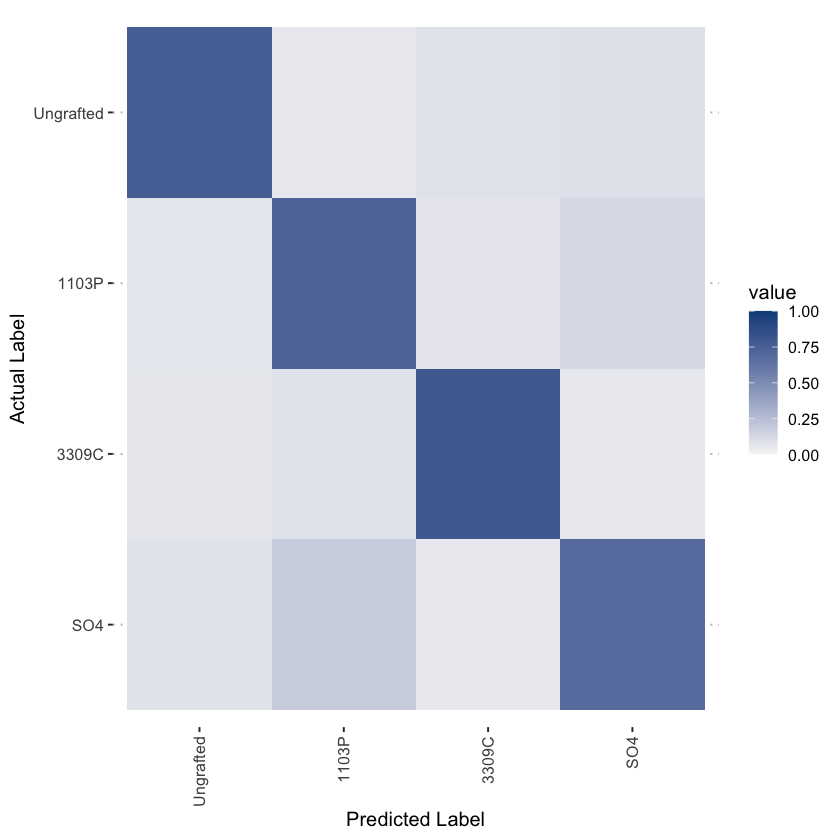

In [12]:
d <- rsIonrf$finalModel
important_features <- as.data.frame(d$importance)
write.csv(important_features, file='2017_ionomics_rootstockImportFeatures.csv', quote=F)
important_features[important_features$MeanDecreaseAccuracy > 0.03,]

d <- rsIonrf$finalModel
d <- data.frame(d$confusion) %>% dplyr::select(-class.error)
drn <- rownames(d)
drs <- rowSums(d)

d <- d %>% mutate_if(is.numeric, funs(./drs))
d$y <- drn
d <- d %>% gather(x, value, Ungrafted:SO4)

ionFig1b <- ggplot(d, aes(x=x, y=rev(y), fill=value)) +
     geom_tile() + 
     scale_fill_gradient(low='grey97', high='dodgerblue4', limits=c(0,1)) + 
     theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
     labs(x='Predicted Label', y='Actual Label') +  
     scale_x_discrete(labels=c('Ungrafted', '1103P', '3309C', 'SO4')) + 
     scale_y_discrete(labels=rev(c('Ungrafted', '1103P', '3309C', 'SO4'))) + 
     ggpubr::theme_pubclean() + 
     theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), legend.position='right',
          axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))

ionFig1b 

pdf('2017_ionomics_RFconfmat_rootstock.pdf')
  ionFig1b
dev.off()

Random Forest 

2052 samples
  20 predictor
   4 classes: 'Ungrafted', '1103P', '3309C', 'SO4' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 2052, 2052, 2052, 2052, 2052, 2052, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    0.7311225  0.6414660
   3    0.7378380  0.6504116
   4    0.7415636  0.6553827
   5    0.7370180  0.6492948
   6    0.7345643  0.6460204
   7    0.7305940  0.6407335
   8    0.7299660  0.6399059
   9    0.7283466  0.6377256
  10    0.7224336  0.6298600
  11    0.7205344  0.6273392
  12    0.7167802  0.6223331
  13    0.7174545  0.6232212
  14    0.7149667  0.6199392
  15    0.7139696  0.6186210
  16    0.7105454  0.6140328
  17    0.7097713  0.6129785
  18    0.7054878  0.6072800
  19    0.7030272  0.6040063
  20    0.7025383  0.6033428

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 4.

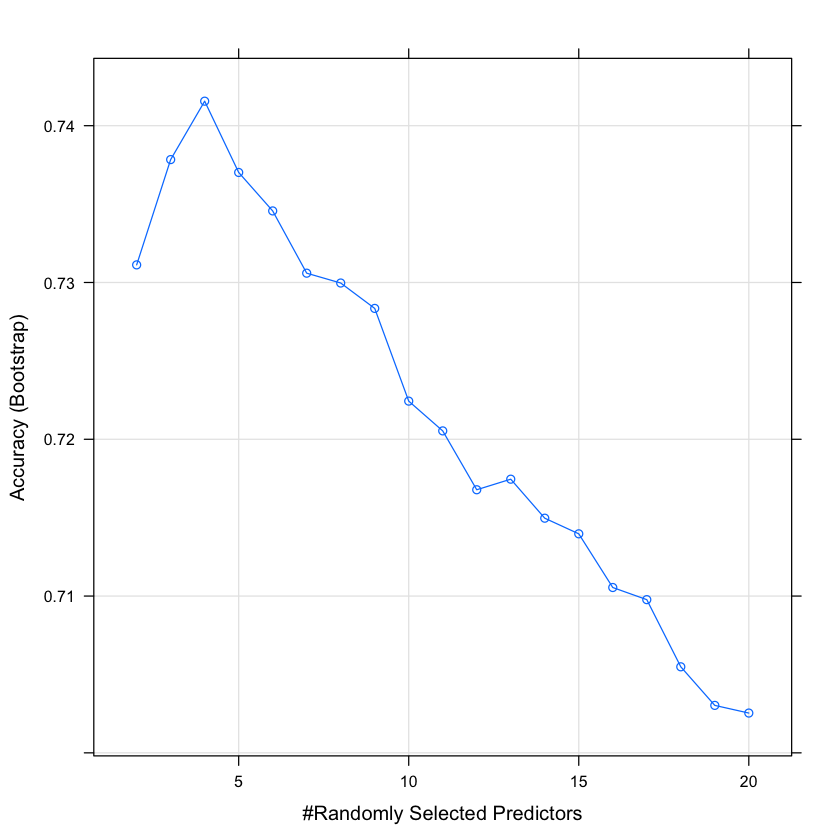

In [13]:
rsIonrf
plot(rsIonrf)

In [14]:
y_pred <- predict(rsIonrf, X_test)

In [15]:
caret::confusionMatrix(y_pred, y_test)

Confusion Matrix and Statistics

           Reference
Prediction  Ungrafted 1103P 3309C SO4
  Ungrafted        86     7    17   6
  1103P             8   104    13  12
  3309C            22     8    91  13
  SO4               5     8     8 105

Overall Statistics
                                          
               Accuracy : 0.7524          
                 95% CI : (0.7127, 0.7892)
    No Information Rate : 0.2651          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.6698          
                                          
 Mcnemar's Test P-Value : 0.6794          

Statistics by Class:

                     Class: Ungrafted Class: 1103P Class: 3309C Class: SO4
Sensitivity                    0.7107       0.8189       0.7054     0.7721
Specificity                    0.9235       0.9145       0.8880     0.9443
Pos Pred Value                 0.7414       0.7591       0.6791     0.8333
Neg Pred Value            

### Phenology

In [16]:
labels <- data$phenology
y_train <- labels[train_idx]
y_test <- labels[test_idx]

pIonGrid <- expand.grid(mtry=(2:20))
pIonrf <- train(x=X_train, y=y_train, method='rf', tuneGrid=pIonGrid, ntree=100, keep.forest=T, importance=1)

,Anthesis,Veraison,Harvest,MeanDecreaseAccuracy,MeanDecreaseGini
B,0.06183413,0.02473183,0.01946910,0.03520994,98.38815
Al,0.03700592,0.04874838,0.05048386,0.04562075,82.86313
P,0.17116575,0.11093449,0.01649988,0.09885495,136.28644
Ca,0.03005654,0.03442073,0.02911750,0.03127978,53.03215
Fe,0.10390513,0.03946130,0.01293846,0.05191522,82.35321
Ni,0.15644865,0.15391292,0.37022075,0.22690112,276.81230
As,0.03659408,0.05685962,0.02156361,0.03836625,66.32923
Sr,0.06016139,0.05145591,0.04563249,0.05225181,95.28344


pdf 
  2

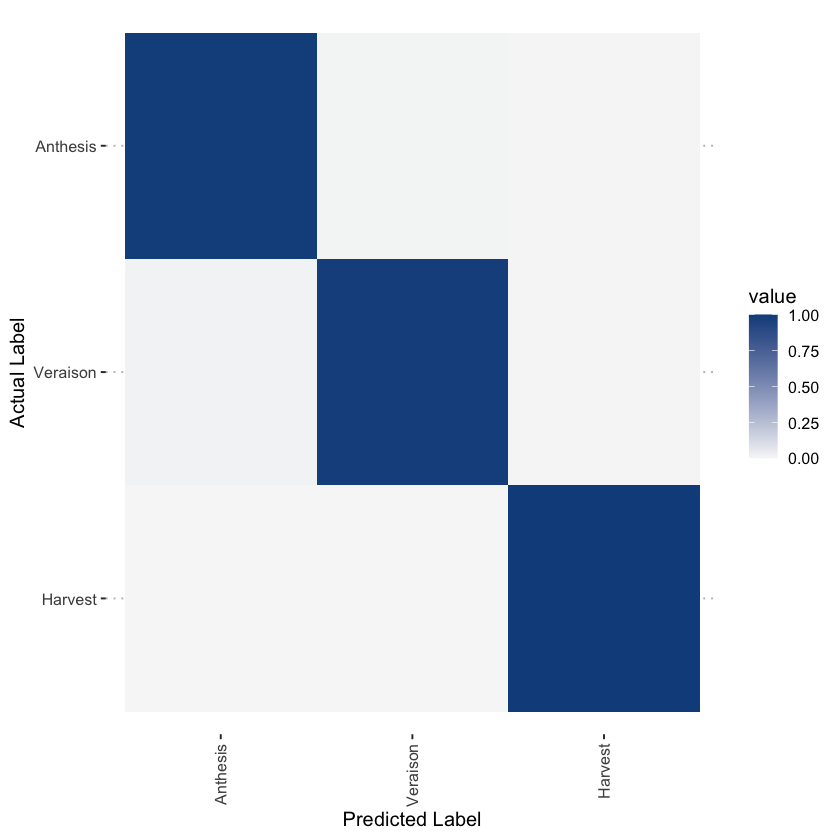

In [17]:
d <- pIonrf$finalModel
important_features <- as.data.frame(d$importance)
write.csv(important_features, file='2017_ionomics_phenologyImportFeatures.csv', quote=F)
important_features[important_features$MeanDecreaseAccuracy > 0.03,]

d <- pIonrf$finalModel
d <- data.frame(d$confusion) %>% dplyr::select(-class.error)
drn <- rownames(d)
drs <- rowSums(d)

d <- d %>% mutate_if(is.numeric, funs(./drs))
d$y <- factor(drn, levels=c('Anthesis', 'Veraison', 'Harvest'))
d <- d %>% gather(x, value, Anthesis:Harvest)
d$x <- factor(d$x, levels=c('Anthesis', 'Veraison', 'Harvest'))

ionFig1a <- ggplot(d, aes(x=x, y=rev(y), fill=value)) +
     geom_tile() + 
     scale_fill_gradient(low='grey97', high='dodgerblue4', limits=c(0,1)) + 
     theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
     labs(x='Predicted Label', y='Actual Label') + 
     scale_x_discrete(labels=c('Anthesis', 'Veraison', 'Harvest')) + 
     scale_y_discrete(labels=c('Harvest', 'Veraison', 'Anthesis')) + 
     ggpubr::theme_pubclean() + 
     theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), legend.position='right',
          axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))


ionFig1a

pdf('2017_ionomics_RFconfmat_phenology.pdf')
  ionFig1a
dev.off()

Random Forest 

2052 samples
  20 predictor
   3 classes: 'Anthesis', 'Veraison', 'Harvest' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 2052, 2052, 2052, 2052, 2052, 2052, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    0.9938981  0.9908371
   3    0.9932524  0.9898681
   4    0.9918133  0.9877076
   5    0.9911123  0.9866537
   6    0.9901674  0.9852365
   7    0.9889434  0.9833973
   8    0.9880382  0.9820393
   9    0.9858158  0.9787034
  10    0.9854438  0.9781442
  11    0.9844921  0.9767157
  12    0.9831635  0.9747196
  13    0.9816771  0.9724882
  14    0.9814060  0.9720811
  15    0.9795423  0.9692809
  16    0.9784269  0.9676067
  17    0.9778000  0.9666664
  18    0.9768302  0.9652091
  19    0.9764636  0.9646615
  20    0.9752908  0.9628999

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 2.

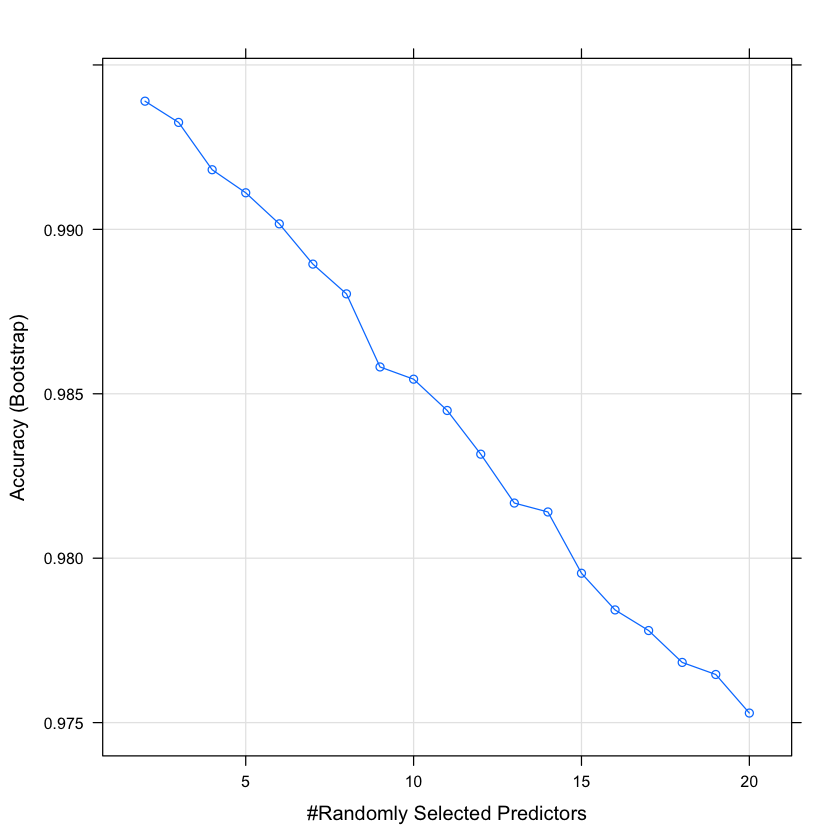

In [18]:
pIonrf
plot(pIonrf)

In [19]:
y_pred <- predict(pIonrf, X_test)

In [20]:
caret::confusionMatrix(y_pred, y_test)

Confusion Matrix and Statistics

          Reference
Prediction Anthesis Veraison Harvest
  Anthesis      175        0       0
  Veraison        1      167       0
  Harvest         1        0     169

Overall Statistics
                                         
               Accuracy : 0.9961         
                 95% CI : (0.986, 0.9995)
    No Information Rate : 0.345          
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.9942         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: Anthesis Class: Veraison Class: Harvest
Sensitivity                   0.9887          1.0000         1.0000
Specificity                   1.0000          0.9971         0.9971
Pos Pred Value                1.0000          0.9940         0.9941
Neg Pred Value                0.9941          1.0000         1.0000
Prevalence                    0.3450  

### Rootstock X Phenology

In [21]:
# fit Random Forest for Rootstock X Phenology

# get train test labels
labels <- as.factor(paste(data$phenology, data$rootstock, sep='_'))
labels <- factor(labels, levels=c('Anthesis_Ungrafted', 'Anthesis_1103P', 'Anthesis_3309C', 'Anthesis_SO4',
                                  'Veraison_Ungrafted', 'Veraison_1103P', 'Veraison_3309C', 'Veraison_SO4', 
                                  'Harvest_Ungrafted', 'Harvest_1103P', 'Harvest_3309C', 'Harvest_SO4'))
y_train <- labels[train_idx]
y_test <- labels[test_idx]

prsIonGrid <- expand.grid(mtry=(2:20))
prsIonrf <- train(x=X_train, y=y_train, method='rf', tuneGrid=prsIonGrid, ntree=100, keep.forest=T, importance=1)

,Anthesis_Ungrafted,Anthesis_1103P,Anthesis_3309C,Anthesis_SO4,Veraison_Ungrafted,Veraison_1103P,Veraison_3309C,Veraison_SO4,Harvest_Ungrafted,Harvest_1103P,Harvest_3309C,Harvest_SO4,MeanDecreaseAccuracy,MeanDecreaseGini
B,0.01435938,0.15082255,0.19858344,0.06012320,0.06445928,0.04121807,0.02450413,0.042122209,0.0513479735,0.035550980,0.012896377,0.01883423,0.05900902,110.99798
Mg,0.06020992,0.04478040,0.03382177,0.01642837,0.14351203,0.08310654,0.02427165,0.018764488,-0.0005598623,0.006780323,0.117949600,0.15181258,0.05799837,134.57109
Al,0.04652342,0.03369495,0.03451129,0.01665256,0.03873914,0.02416473,0.03166488,0.020377227,0.0113243694,0.044779690,0.035675512,0.05221756,0.03253555,69.26656
P,0.13167569,0.27849425,0.11551090,0.17346179,0.12956900,0.08214113,0.14229489,0.068162029,0.0714379370,0.047728537,0.060722595,0.03689010,0.11044553,150.18072
S,0.02133860,0.01998792,0.03799358,0.01577163,0.01038218,0.04130456,0.03397735,0.039184275,0.0269678173,0.024027041,0.045164032,0.05230595,0.03060245,82.08273
Co,0.04433517,0.14217004,0.02867057,0.02795708,0.01307341,0.03890451,0.01738682,0.005573016,0.0269303089,0.004635631,0.006149754,0.01008444,0.03013778,88.84896
Ni,0.12429526,0.14574062,0.11909043,0.20026266,0.09894626,0.10351197,0.09564258,0.238429883,0.2124663344,0.281229257,0.195444054,0.19521666,0.16703982,256.52806
Sr,0.04747069,0.04708680,0.11602620,0.04845159,0.08011688,0.05769195,-0.01012099,0.121983588,0.0412691751,0.074508676,0.117608289,0.02959646,0.06457677,118.57178
Mo,0.01928223,0.06607021,0.03455956,0.12668529,0.07304851,0.03959338,0.05184812,0.042356746,0.0335834111,0.020345113,0.099218767,0.02470616,0.05262551,125.85919


pdf 
  2

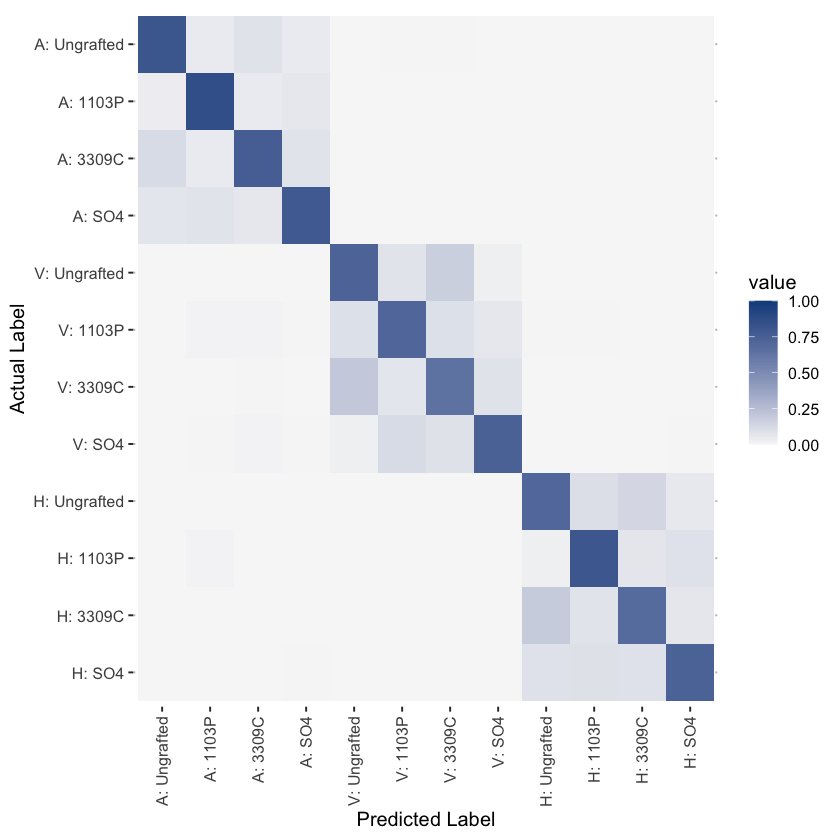

In [22]:
d <- prsIonrf$finalModel
important_features <- as.data.frame(d$importance)
write.csv(important_features, file='2017_ionomics_rootstockPhenologyImportFeatures.csv', quote=F)
important_features[important_features$MeanDecreaseAccuracy > 0.03,]

d <- prsIonrf$finalModel
d <- data.frame(d$confusion) %>% dplyr::select(Anthesis_Ungrafted:Harvest_SO4)
drn <- rownames(d)
drs <- rowSums(d)

d <- d %>% mutate_if(is.numeric, funs(./drs))
d$y <- factor(drn, levels=c('Anthesis_Ungrafted', 'Anthesis_1103P', 'Anthesis_3309C', 'Anthesis_SO4',
                                  'Veraison_Ungrafted', 'Veraison_1103P', 'Veraison_3309C', 'Veraison_SO4', 
                                  'Harvest_Ungrafted', 'Harvest_1103P', 'Harvest_3309C', 'Harvest_SO4'))

d <- d %>% gather(x, value, Anthesis_Ungrafted:Harvest_SO4)
d$x <- factor(d$x, levels=c('Anthesis_Ungrafted', 'Anthesis_1103P', 'Anthesis_3309C', 'Anthesis_SO4',
                                  'Veraison_Ungrafted', 'Veraison_1103P', 'Veraison_3309C', 'Veraison_SO4', 
                                  'Harvest_Ungrafted', 'Harvest_1103P', 'Harvest_3309C', 'Harvest_SO4'))

ionFig1c <- ggplot(d, aes(x=x, y=rev(y), fill=value)) +
     geom_tile() + 
     scale_fill_gradient(low='grey97', high='dodgerblue4', limits=c(0,1)) + 
     theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
     labs(x='Predicted Label', y='Actual Label') + 
     scale_x_discrete(labels=c("A: Ungrafted", "A: 1103P", "A: 3309C", "A: SO4",
                               "V: Ungrafted", "V: 1103P", "V: 3309C", "V: SO4",
                               "H: Ungrafted", "H: 1103P", "H: 3309C", "H: SO4")) + 
     scale_y_discrete(labels=rev(c("A: Ungrafted", "A: 1103P", "A: 3309C", "A: SO4",
                               "V: Ungrafted", "V: 1103P", "V: 3309C", "V: SO4",
                               "H: Ungrafted", "H: 1103P", "H: 3309C", "H: SO4"))) + 
     ggpubr::theme_pubclean() + 
     theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), legend.position='right',
          axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))


ionFig1c

pdf('2017_ionomics_RFconfmat_phenologyRootstock.pdf')
  ionFig1c 
dev.off()

rf_col[[3]] <- rf

Random Forest 

2052 samples
  20 predictor
  12 classes: 'Anthesis_Ungrafted', 'Anthesis_1103P', 'Anthesis_3309C', 'Anthesis_SO4', 'Veraison_Ungrafted', 'Veraison_1103P', 'Veraison_3309C', 'Veraison_SO4', 'Harvest_Ungrafted', 'Harvest_1103P', 'Harvest_3309C', 'Harvest_SO4' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 2052, 2052, 2052, 2052, 2052, 2052, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    0.7323567  0.7079628
   3    0.7425447  0.7190589
   4    0.7436159  0.7202161
   5    0.7416639  0.7180831
   6    0.7430835  0.7196362
   7    0.7399099  0.7161694
   8    0.7364614  0.7124053
   9    0.7366207  0.7125683
  10    0.7324610  0.7080255
  11    0.7313399  0.7067966
  12    0.7266259  0.7016588
  13    0.7242852  0.6991155
  14    0.7235658  0.6983217
  15    0.7158027  0.6898492
  16    0.7154955  0.6895167
  17    0.7142578  0.6881541
  18    0.7103494  0.6839004
  19    0.7070276  0.6802723
  20  

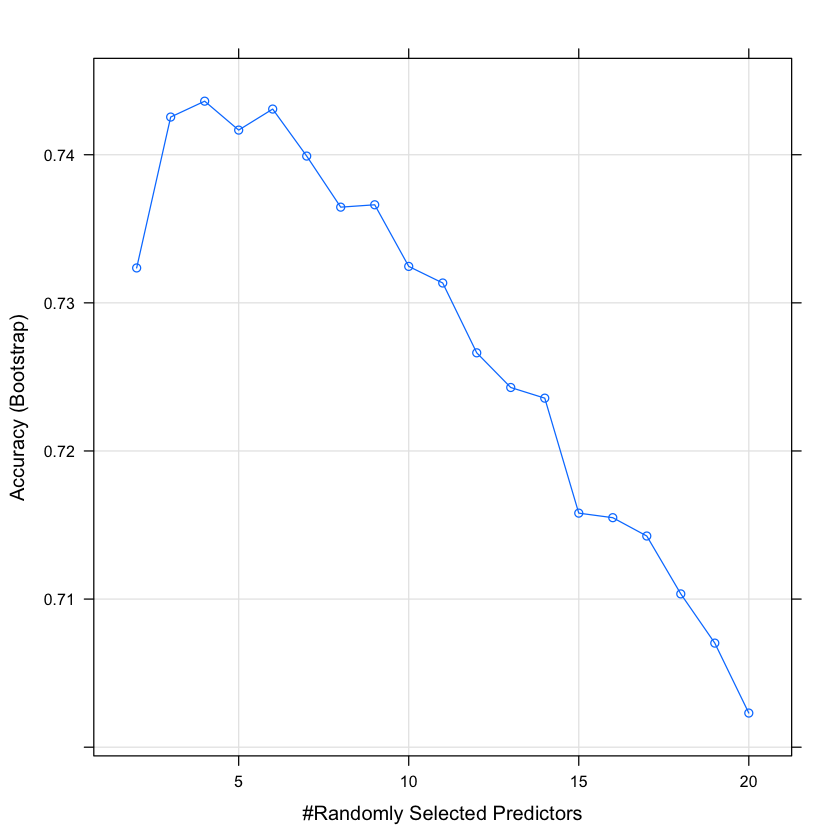

In [23]:
prsIonrf
plot(prsIonrf)

In [24]:
y_pred <- predict(prsIonrf, X_test)

In [25]:
caret::confusionMatrix(y_pred, y_test)

Confusion Matrix and Statistics

                    Reference
Prediction           Anthesis_Ungrafted Anthesis_1103P Anthesis_3309C
  Anthesis_Ungrafted                 36              3              2
  Anthesis_1103P                      3             39              5
  Anthesis_3309C                      4              0             36
  Anthesis_SO4                        0              1              1
  Veraison_Ungrafted                  0              0              0
  Veraison_1103P                      0              0              0
  Veraison_3309C                      0              0              0
  Veraison_SO4                        0              0              0
  Harvest_Ungrafted                   0              0              0
  Harvest_1103P                       0              0              0
  Harvest_3309C                       0              0              0
  Harvest_SO4                         0              0              0
                    Referen

In [26]:
# Leaf position
labels <- data$leafpos
y_train <- labels[train_idx]
y_test <- labels[test_idx]

lIonGrid <- expand.grid(mtry=(2:20))
lIonrf <- train(x=X_train, y=y_train, method='rf', tuneGrid=lIonGrid, ntree=100, keep.forest=T, importance=1)

,X,Y,Z,MeanDecreaseAccuracy,MeanDecreaseGini
Na,0.08050721,0.02987185,0.006730547,0.03906971,84.66590
Al,0.05575751,0.06456830,0.048186274,0.05607538,77.50358
S,0.06451142,0.02227601,0.047241089,0.04481355,96.99865
K,0.05132598,0.03136683,0.015559893,0.03283042,71.24235
Fe,0.02445932,0.05630335,0.066313900,0.04904410,103.33653
Mn,0.04074687,0.04199524,0.130802321,0.07136414,146.26042
Cu,0.05932605,0.03955946,0.049073405,0.04941551,93.03950
Zn,0.08875502,0.05942332,0.024332241,0.05751953,103.44485
As,0.03814734,0.04314799,0.060228063,0.04713218,76.28952
Rb,0.12058044,0.03914774,0.050908497,0.07054438,103.33887


pdf 
  2

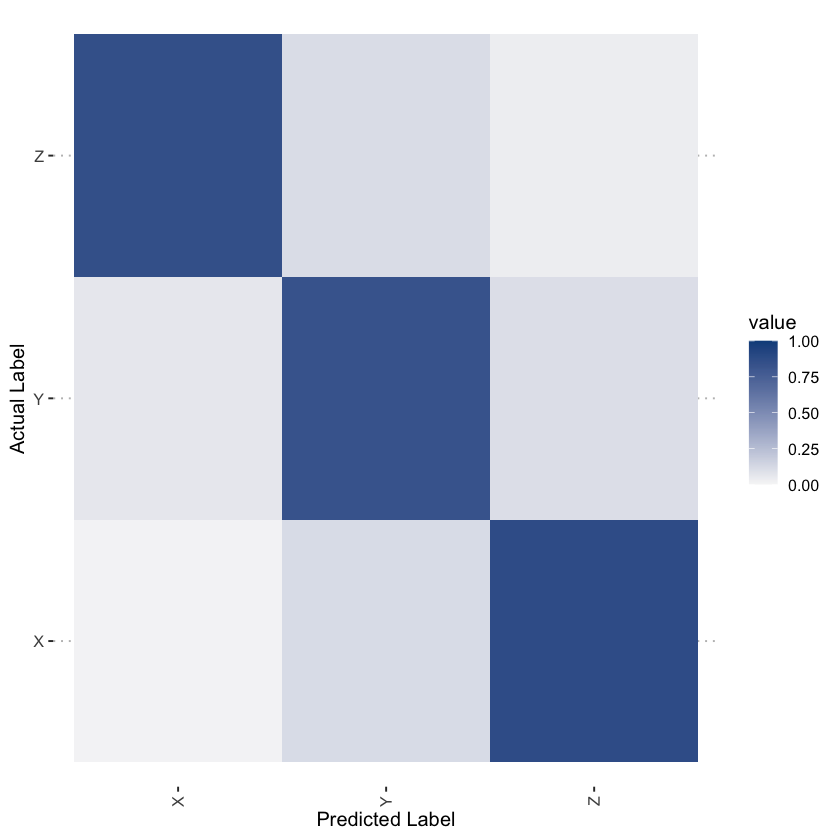

In [27]:
d <- lIonrf$finalModel
important_features <- as.data.frame(d$importance)
write.csv(important_features, file='2017_ionomics_leafpositionImportFeatures.csv', quote=F)
important_features[important_features$MeanDecreaseAccuracy > 0.03,]

d <- lIonrf$finalModel
d <- data.frame(d$confusion) %>% dplyr::select(-class.error)
drn <- rownames(d)
drs <- rowSums(d)

d <- d %>% mutate_if(is.numeric, funs(./drs))
d$y <- factor(drn, levels=c('X', 'Y', 'Z'))
d <- d %>% gather(x, value, X:Z)
d$x <- factor(d$x, levels=c('X', 'Y', 'Z'))

ionFig1a <- ggplot(d, aes(x=x, y=rev(y), fill=value)) +
     geom_tile() + 
     scale_fill_gradient(low='grey97', high='dodgerblue4', limits=c(0,1)) + 
     theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
     labs(x='Predicted Label', y='Actual Label') + 
     scale_x_discrete(labels=c('X', 'Y', 'Z')) + 
     scale_y_discrete(labels=c('X', 'Y', 'Z')) + 
     ggpubr::theme_pubclean() + 
     theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), legend.position='right',
          axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))


ionFig1a

pdf('2017_ionomics_RFconfmat_leafposition.pdf')
  ionFig1a
dev.off()

Random Forest 

2052 samples
  20 predictor
   3 classes: 'X', 'Y', 'Z' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 2052, 2052, 2052, 2052, 2052, 2052, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    0.8568643  0.7852338
   3    0.8569909  0.7854137
   4    0.8532127  0.7797538
   5    0.8542204  0.7812623
   6    0.8516941  0.7774604
   7    0.8502142  0.7752469
   8    0.8500702  0.7750449
   9    0.8470414  0.7704895
  10    0.8455644  0.7682775
  11    0.8430009  0.7644398
  12    0.8437351  0.7655428
  13    0.8396719  0.7594333
  14    0.8393020  0.7588952
  15    0.8373241  0.7559101
  16    0.8379489  0.7568373
  17    0.8348743  0.7522560
  18    0.8342120  0.7512274
  19    0.8338712  0.7507200
  20    0.8300763  0.7450049

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 3.

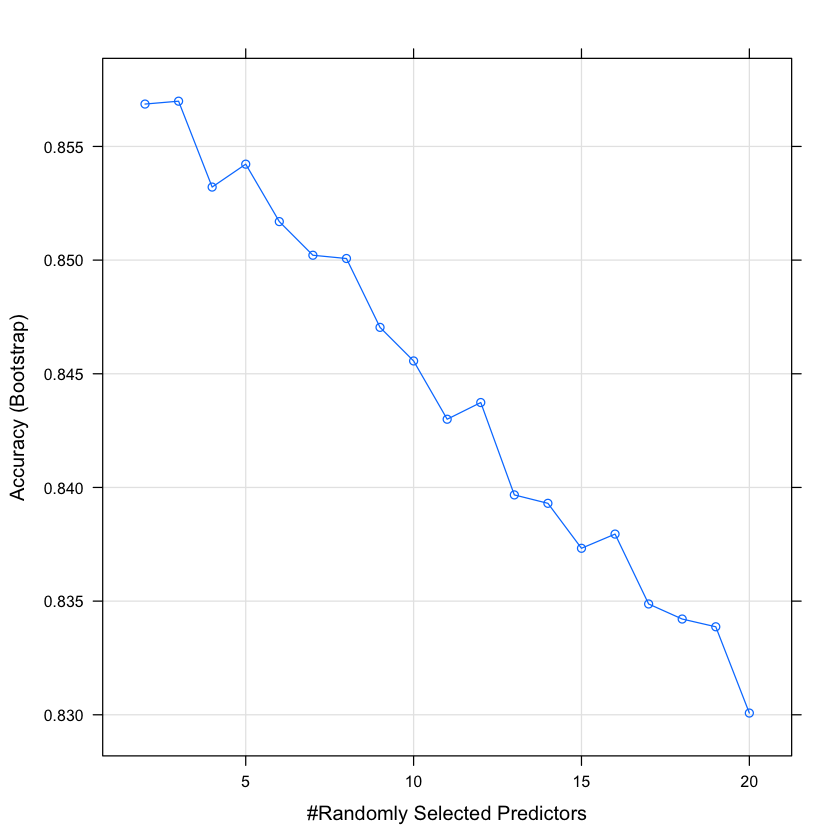

In [28]:
lIonrf
plot(lIonrf)

In [29]:
y_pred <- predict(lIonrf, X_test)
caret::confusionMatrix(y_pred, y_test)

Confusion Matrix and Statistics

          Reference
Prediction   X   Y   Z
         X 142   6   1
         Y  17 152  20
         Z   4  23 148

Overall Statistics
                                          
               Accuracy : 0.8616          
                 95% CI : (0.8287, 0.8903)
    No Information Rate : 0.3528          
    P-Value [Acc > NIR] : < 2e-16         
                                          
                  Kappa : 0.792           
                                          
 Mcnemar's Test P-Value : 0.06377         

Statistics by Class:

                     Class: X Class: Y Class: Z
Sensitivity            0.8712   0.8398   0.8757
Specificity            0.9800   0.8886   0.9215
Pos Pred Value         0.9530   0.8042   0.8457
Neg Pred Value         0.9423   0.9105   0.9379
Prevalence             0.3177   0.3528   0.3294
Detection Rate         0.2768   0.2963   0.2885
Detection Prevalence   0.2904   0.3684   0.3411
Balanced Accuracy      0.9256   0.8642   

In [30]:
# fit Random Forest for Leaf Position by Phenology

# get train test labels
labels <- as.factor(paste(data$phenology, data$leafpos, sep='_'))
labels <- factor(labels, levels=c('Anthesis_X', 'Anthesis_Y', 'Anthesis_Z',
                                  'Veraison_X', 'Veraison_Y', 'Veraison_Z', 
                                  'Harvest_X', 'Harvest_Y', 'Harvest_Z'))
y_train <- labels[train_idx]
y_test <- labels[test_idx]

plIonGrid <- expand.grid(mtry=(2:20))
plIonrf <- train(x=X_train, y=y_train, method='rf', tuneGrid=plIonGrid, ntree=100, keep.forest=T, importance=1)

,Anthesis_X,Anthesis_Y,Anthesis_Z,Veraison_X,Veraison_Y,Veraison_Z,Harvest_X,Harvest_Y,Harvest_Z,MeanDecreaseAccuracy,MeanDecreaseGini
B,0.020277076,0.03357943,0.09814479,0.01243624,0.099702018,0.0380231958,0.022396831,0.056884476,0.036900200,0.04620036,98.19294
Al,0.189284743,0.17445937,0.10260681,0.02713603,0.031022273,0.1802575781,0.060852305,0.063198048,0.024727894,0.09428793,116.10823
P,0.469812653,0.17574270,0.15098505,0.07554179,0.209914643,0.1098774765,0.096143880,0.041618491,0.022702380,0.14876662,203.41137
S,0.014836121,0.04696901,0.02055325,0.04044798,0.055264752,0.0875392113,0.110498230,-0.005217383,0.024338492,0.04446503,85.74127
K,0.165453814,0.06993556,0.02822332,0.04955962,0.031894917,0.0003073845,0.021453507,0.013644862,0.034428160,0.04596128,79.12438
Ca,0.017764300,0.03737618,0.05021306,0.02175334,0.005217491,0.0809576346,0.060260083,0.052652497,0.019784636,0.03811367,78.54263
Fe,0.061003821,0.07052867,0.11206735,0.04914729,0.158406995,0.0675962117,0.053948882,0.040316901,0.032488522,0.07211403,116.69366
Mn,0.039076188,0.05019899,0.18373247,0.07045763,0.042213577,0.0747008439,0.041835201,-0.003237804,0.063137992,0.06225000,109.39461
Ni,0.122783012,0.21649821,0.13247994,0.10220787,0.122102667,0.1313397501,0.308428653,0.234967404,0.256517897,0.18153327,177.46409
Cu,0.132471565,0.05686176,0.07421364,0.12850053,0.097516604,0.1125236792,0.010286258,0.004216894,0.022590562,0.07063725,99.06043


pdf 
  2

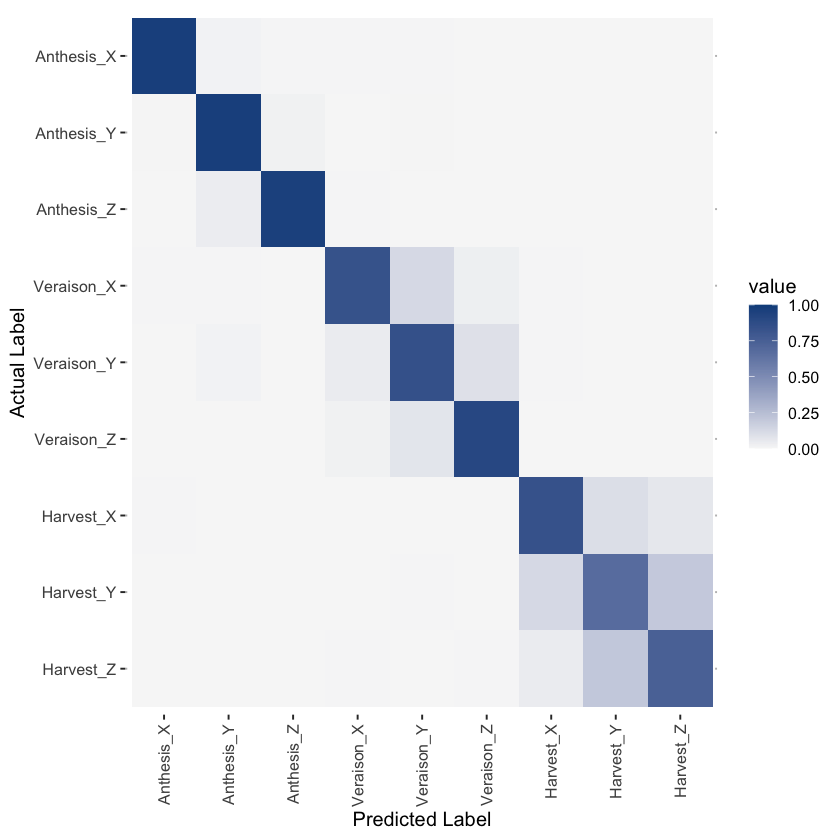

In [31]:
d <- plIonrf$finalModel
important_features <- as.data.frame(d$importance)
write.csv(important_features, file='2017_ionomics_leafposPhenologyImportFeatures.csv', quote=F)
important_features[important_features$MeanDecreaseAccuracy > 0.03,]

d <- plIonrf$finalModel
d <- data.frame(d$confusion) %>% dplyr::select(Anthesis_X:Harvest_Z)
drn <- rownames(d)
drs <- rowSums(d)

d <- d %>% mutate_if(is.numeric, funs(./drs))
d$y <- factor(drn, levels=c('Anthesis_X', 'Anthesis_Y', 'Anthesis_Z',
                                  'Veraison_X', 'Veraison_Y', 'Veraison_Z', 
                                  'Harvest_X', 'Harvest_Y', 'Harvest_Z'))

d <- d %>% gather(x, value, Anthesis_X:Harvest_Z)
d$x <- factor(d$x, levels=c('Anthesis_X', 'Anthesis_Y', 'Anthesis_Z',
                                  'Veraison_X', 'Veraison_Y', 'Veraison_Z', 
                                  'Harvest_X', 'Harvest_Y', 'Harvest_Z'))

ionFig1c <- ggplot(d, aes(x=x, y=rev(y), fill=value)) +
     geom_tile() + 
     scale_fill_gradient(low='grey97', high='dodgerblue4', limits=c(0,1)) + 
     theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
     labs(x='Predicted Label', y='Actual Label') + 
     scale_x_discrete(labels=c('Anthesis_X', 'Anthesis_Y', 'Anthesis_Z',
                                  'Veraison_X', 'Veraison_Y', 'Veraison_Z', 
                                  'Harvest_X', 'Harvest_Y', 'Harvest_Z')) + 
     scale_y_discrete(labels=rev(c('Anthesis_X', 'Anthesis_Y', 'Anthesis_Z',
                                  'Veraison_X', 'Veraison_Y', 'Veraison_Z', 
                                  'Harvest_X', 'Harvest_Y', 'Harvest_Z'))) + 
     ggpubr::theme_pubclean() + 
     theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), legend.position='right',
          axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))


ionFig1c

pdf('2017_ionomics_RFconfmat_leafposPhenology.pdf')
  ionFig1c 
dev.off()

Random Forest 

2052 samples
  20 predictor
   9 classes: 'Anthesis_X', 'Anthesis_Y', 'Anthesis_Z', 'Veraison_X', 'Veraison_Y', 'Veraison_Z', 'Harvest_X', 'Harvest_Y', 'Harvest_Z' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 2052, 2052, 2052, 2052, 2052, 2052, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    0.8618128  0.8444531
   3    0.8625880  0.8453218
   4    0.8621636  0.8448438
   5    0.8574168  0.8394974
   6    0.8566512  0.8386408
   7    0.8550358  0.8368196
   8    0.8535207  0.8351122
   9    0.8524083  0.8338596
  10    0.8499417  0.8310859
  11    0.8478924  0.8287755
  12    0.8478852  0.8287730
  13    0.8457853  0.8264109
  14    0.8441434  0.8245582
  15    0.8447987  0.8252975
  16    0.8429784  0.8232499
  17    0.8416141  0.8217151
  18    0.8408120  0.8208160
  19    0.8383100  0.8179958
  20    0.8375771  0.8171695

Accuracy was used to select the optimal model using the largest value.


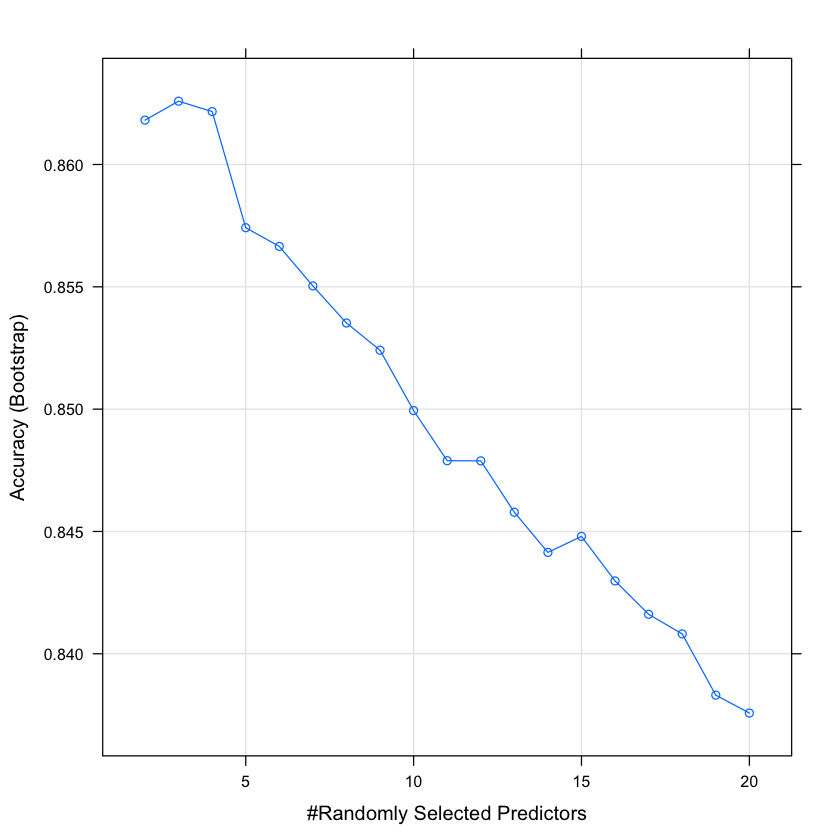

In [32]:
plIonrf
plot(plIonrf)

In [33]:
y_pred <- predict(plIonrf, X_test)
caret::confusionMatrix(y_pred, y_test)

Confusion Matrix and Statistics

            Reference
Prediction   Anthesis_X Anthesis_Y Anthesis_Z Veraison_X Veraison_Y Veraison_Z
  Anthesis_X         54          1          0          0          0          0
  Anthesis_Y          0         59          2          0          1          0
  Anthesis_Z          0          2         57          0          0          1
  Veraison_X          0          0          0         52          0          0
  Veraison_Y          0          0          0          3         48          6
  Veraison_Z          0          0          1          1          3         52
  Harvest_X           0          0          0          0          0          0
  Harvest_Y           0          1          0          0          0          0
  Harvest_Z           0          0          0          0          0          0
            Reference
Prediction   Harvest_X Harvest_Y Harvest_Z
  Anthesis_X         0         0         0
  Anthesis_Y         0         0         0
  An

In [35]:
# fit Random Forest for Rootstock X Phenology

# get train test labels
labels <- as.factor(paste(data$leafpos, data$rootstock, sep='_'))
labels <- factor(labels, levels=c('X_Ungrafted', 'X_1103P', 'X_3309C', 'X_SO4',
                                  'Y_Ungrafted', 'Y_1103P', 'Y_3309C', 'Y_SO4', 
                                  'Z_Ungrafted', 'Z_1103P', 'Z_3309C', 'Z_SO4'))
y_train <- labels[train_idx]
y_test <- labels[test_idx]

lrsIonGrid <- expand.grid(mtry=(2:20))
lrsIonrf <- train(x=X_train, y=y_train, method='rf', tuneGrid=lrsIonGrid, ntree=100, keep.forest=T, importance=1)

,X_Ungrafted,X_1103P,X_3309C,X_SO4,Y_Ungrafted,Y_1103P,Y_3309C,Y_SO4,Z_Ungrafted,Z_1103P,Z_3309C,Z_SO4,MeanDecreaseAccuracy,MeanDecreaseGini
Mg,0.01072738,0.01144694,0.01671079,0.028350398,0.06327774,0.03026890,0.04738731,0.03220617,0.07205097,0.04202910,0.05026717,0.02252981,0.03549375,109.18618
P,0.03984477,0.03449981,0.02051515,0.007724608,0.02284264,0.04936812,0.04034647,0.03210085,0.04464044,0.03613820,0.04939395,0.02535030,0.03343613,98.60810
S,0.04941049,0.03182705,0.03370779,0.018505353,0.04631772,0.03694063,0.05813081,0.05918111,0.02281915,0.10740627,0.04162883,0.11735541,0.05133405,116.48832
Fe,0.01941089,0.01699610,0.02271633,0.010507247,0.03458030,0.02636546,0.03475750,0.04332322,0.05437883,0.09544436,0.02937177,0.02655626,0.03417559,97.60642
Mn,0.04524332,0.01116757,0.02918451,0.019641564,0.06558327,0.01069031,0.04573038,0.02221030,0.08216600,0.08278662,0.07188339,0.06770407,0.04581051,105.60463
Ni,0.02462250,0.04874952,0.02607378,0.117302061,0.02710410,0.06722099,0.03112610,0.08776893,0.03276237,0.03638884,0.02320761,0.07528842,0.04922596,137.44857
Cu,0.05949545,0.10411607,0.03068644,0.029976051,0.02864428,0.03743646,0.03118306,0.01289835,0.02911780,0.02161154,0.06469129,0.02944441,0.04037495,104.20394
Zn,0.04899963,0.03046801,0.04514535,0.036815564,0.05429375,0.02803490,0.03279453,0.03690875,0.02408276,0.01182287,0.04172690,0.01368874,0.03357783,88.05377
As,0.01440000,0.01555051,0.02030432,0.012120549,0.05713973,0.03839782,0.05236758,0.02836875,0.02464609,0.04548840,0.03357111,0.04674615,0.03209299,83.39594
Rb,0.04513933,0.12411319,0.06105240,0.061957288,0.04442602,0.03037073,0.04343764,0.02185534,0.08648303,0.03776308,0.03350493,0.01994608,0.05123744,113.43365


pdf 
  2

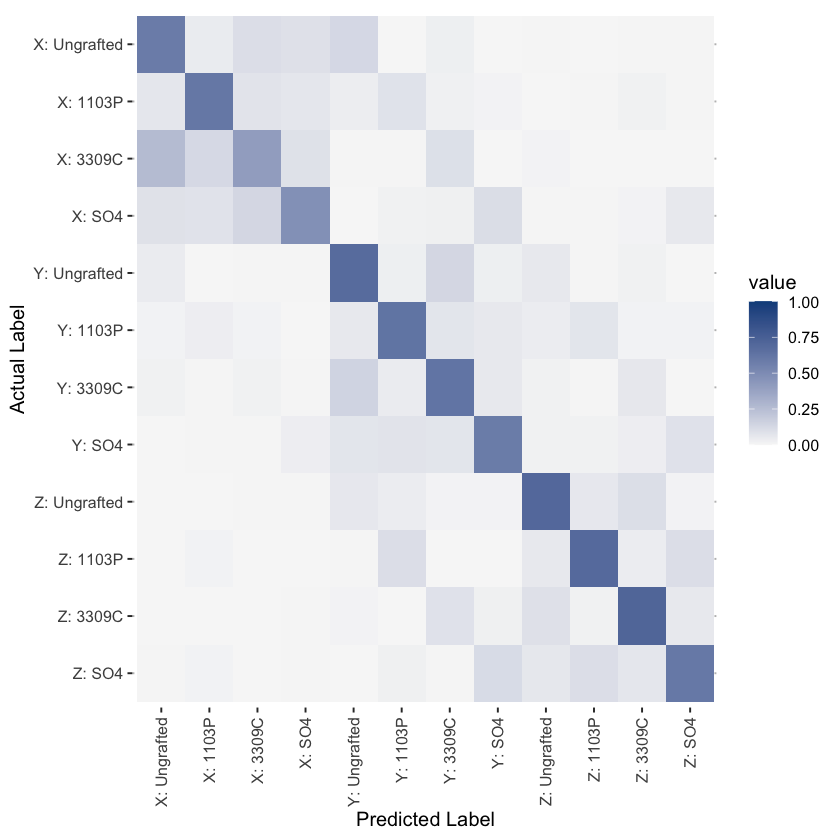

In [36]:
d <- lrsIonrf$finalModel
important_features <- as.data.frame(d$importance)
write.csv(important_features, file='2017_ionomics_rootstockLeafposImportFeatures.csv', quote=F)
important_features[important_features$MeanDecreaseAccuracy > 0.03,]

d <- lrsIonrf$finalModel
d <- data.frame(d$confusion) %>% dplyr::select(X_Ungrafted:Z_SO4)
drn <- rownames(d)
drs <- rowSums(d)

d <- d %>% mutate_if(is.numeric, funs(./drs))
d$y <- factor(drn, levels=c('X_Ungrafted', 'X_1103P', 'X_3309C', 'X_SO4',
                                  'Y_Ungrafted', 'Y_1103P', 'Y_3309C', 'Y_SO4', 
                                  'Z_Ungrafted', 'Z_1103P', 'Z_3309C', 'Z_SO4'))

d <- d %>% gather(x, value, X_Ungrafted:Z_SO4)
d$x <- factor(d$x, levels=c('X_Ungrafted', 'X_1103P', 'X_3309C', 'X_SO4',
                                  'Y_Ungrafted', 'Y_1103P', 'Y_3309C', 'Y_SO4', 
                                  'Z_Ungrafted', 'Z_1103P', 'Z_3309C', 'Z_SO4'))

ionFig1c <- ggplot(d, aes(x=x, y=rev(y), fill=value)) +
     geom_tile() + 
     scale_fill_gradient(low='grey97', high='dodgerblue4', limits=c(0,1)) + 
     theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
     labs(x='Predicted Label', y='Actual Label') + 
     scale_x_discrete(labels=c('X: Ungrafted', 'X: 1103P', 'X: 3309C', 'X: SO4',
                                  'Y: Ungrafted', 'Y: 1103P', 'Y: 3309C', 'Y: SO4', 
                                  'Z: Ungrafted', 'Z: 1103P', 'Z: 3309C', 'Z: SO4')) + 
     scale_y_discrete(labels=rev(c('X: Ungrafted', 'X: 1103P', 'X: 3309C', 'X: SO4',
                                  'Y: Ungrafted', 'Y: 1103P', 'Y: 3309C', 'Y: SO4', 
                                  'Z: Ungrafted', 'Z: 1103P', 'Z: 3309C', 'Z: SO4'))) + 
     ggpubr::theme_pubclean() + 
     theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), legend.position='right',
          axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))


ionFig1c

pdf('2017_ionomics_RFconfmat_leafposRootstock.pdf')
  ionFig1c 
dev.off()

Random Forest 

2052 samples
  20 predictor
  12 classes: 'X_Ungrafted', 'X_1103P', 'X_3309C', 'X_SO4', 'Y_Ungrafted', 'Y_1103P', 'Y_3309C', 'Y_SO4', 'Z_Ungrafted', 'Z_1103P', 'Z_3309C', 'Z_SO4' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 2052, 2052, 2052, 2052, 2052, 2052, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    0.6048503  0.5689761
   3    0.6098398  0.5744047
   4    0.6097098  0.5742463
   5    0.6069298  0.5712169
   6    0.6060260  0.5701938
   7    0.6078950  0.5722294
   8    0.6042757  0.5682819
   9    0.5989636  0.5624888
  10    0.5974727  0.5608441
  11    0.5965920  0.5598990
  12    0.5924604  0.5553917
  13    0.5880149  0.5505425
  14    0.5862118  0.5486006
  15    0.5833258  0.5454364
  16    0.5861869  0.5485252
  17    0.5837518  0.5458903
  18    0.5751159  0.5364703
  19    0.5758910  0.5373173
  20    0.5718220  0.5328826

Accuracy was used to select the optimal model using the 

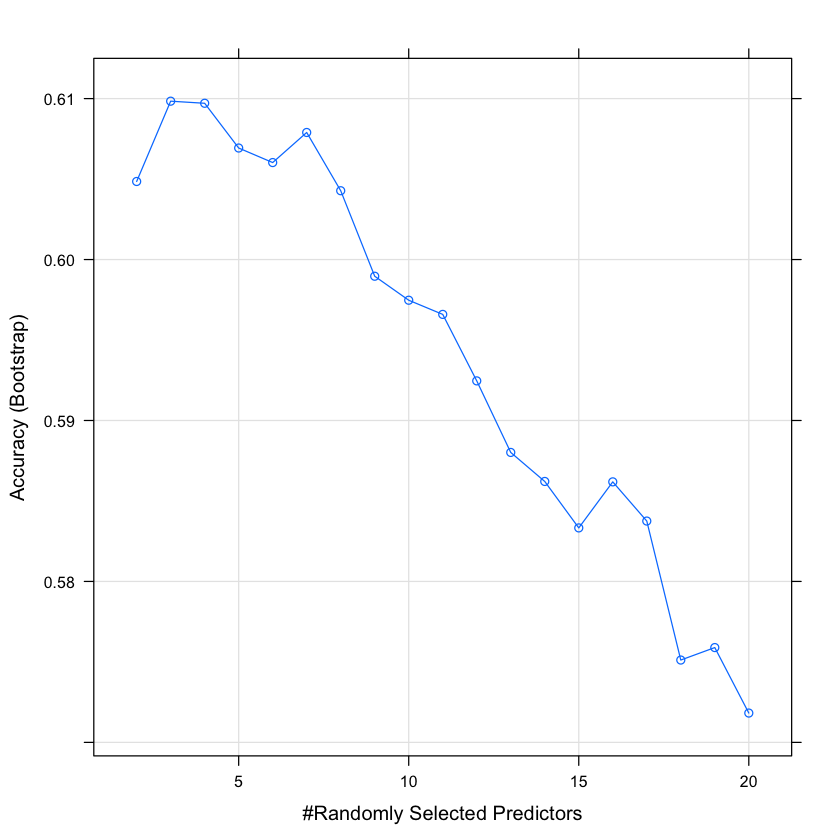

In [37]:
lrsIonrf
plot(lrsIonrf)

In [38]:
y_pred <- predict(lrsIonrf, X_test)
caret::confusionMatrix(y_pred, y_test)

Confusion Matrix and Statistics

             Reference
Prediction    X_Ungrafted X_1103P X_3309C X_SO4 Y_Ungrafted Y_1103P Y_3309C
  X_Ungrafted          24       4       8     2           2       0       1
  X_1103P               4      21       8     2           0       3       0
  X_3309C               3       3      20     2           0       0       0
  X_SO4                 2       0       5    29           0       0       0
  Y_Ungrafted           5       1       0     0          27       3       6
  Y_1103P               0       4       0     2           2      33       3
  Y_3309C               2       0       1     0           5       1      31
  Y_SO4                 0       0       0     4           1       0       4
  Z_Ungrafted           0       1       0     1           3       2       0
  Z_1103P               0       0       0     0           0       5       0
  Z_3309C               0       0       3     2           2       0       1
  Z_SO4                 0       

## LDA for Viz

This is an older version of some LDA code (before I realized LDA has a predict method...). As will all data types, I just use the LDA for visualiztion because it makes more interesting figures than the random forest. 

In [216]:
dot <- function(x, y){
    return(x %*% y)
}

png 
  2

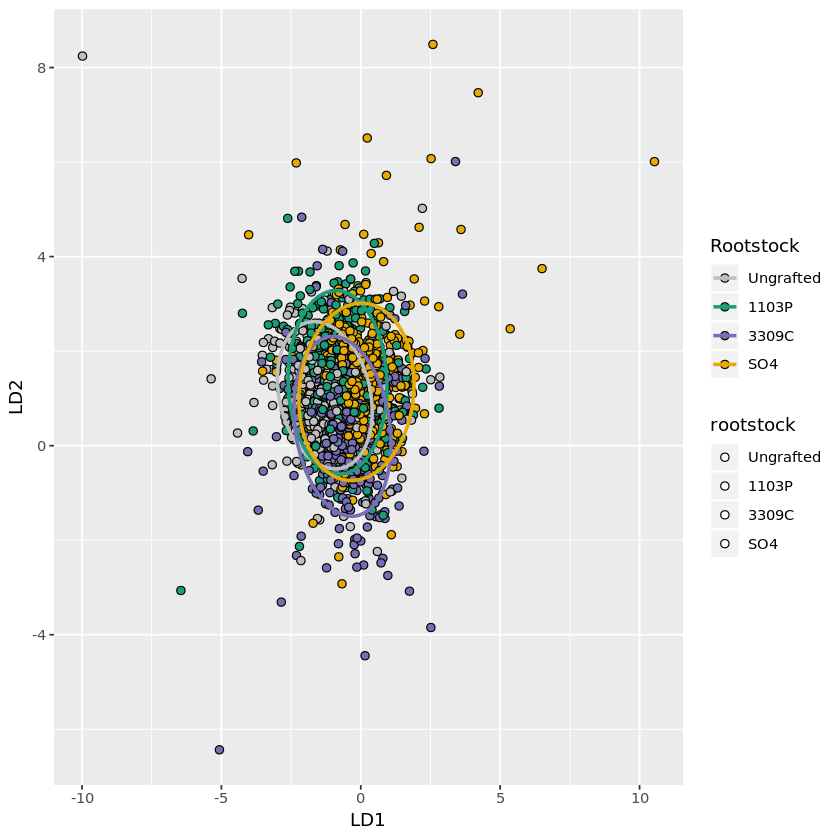

png 
  2

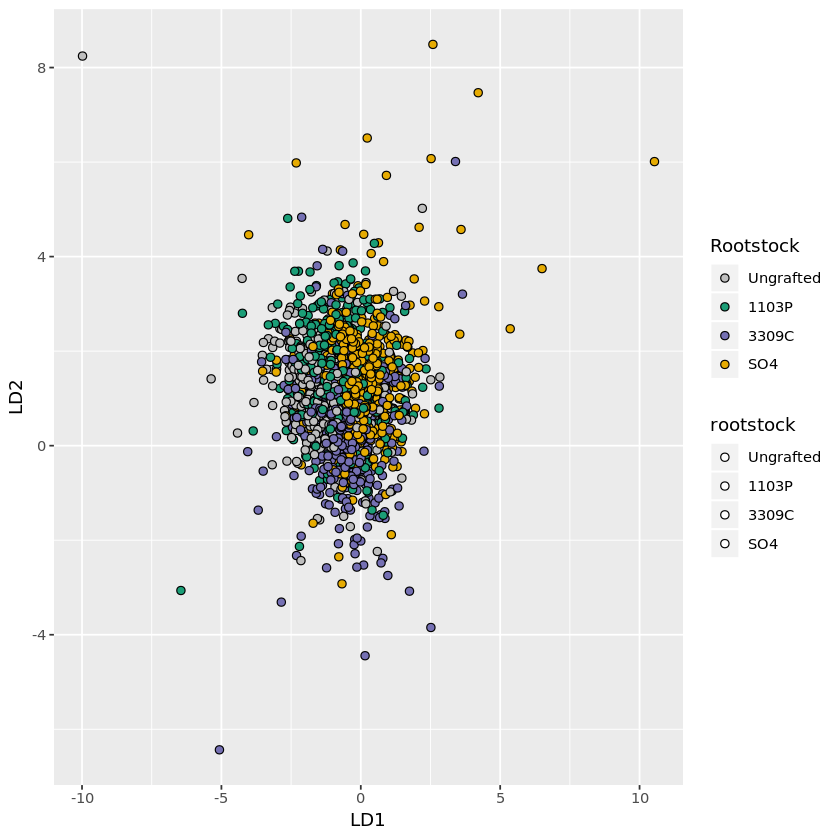

In [218]:
d <- data %>% dplyr::select(B:Cd)
d_norm <- scale(d, center=TRUE, scale=TRUE)
y <- data$rootstock
lda <- lda(d,y)
lda.scale <- data.frame(lda$scaling)

lda.plot <- data.frame(LD1=apply(d, 1, dot, y=lda.scale$LD1), LD2=apply(d, 1, dot, y=lda.scale$LD2))
lda.plot$rootstock <- data$rootstock
# lda.plot$rootstock <- factor(lda.plot$rootstock, levels=c('OWN', '1103P', '3309C', 'SO4'))

p <- ggplot(lda.plot, aes(x=LD1, y=LD2, fill=rootstock)) + 
  geom_point(aes(shape=rootstock), size=2) +
  stat_ellipse(aes(color=rootstock), linetype=1, size=1, level=0.95) + 
  scale_shape_manual(values=c(21, 21, 21, 21)) +
  scale_color_manual(name='Rootstock', values=rs_c_pal) + 
  scale_fill_manual(name='Rootstock', values=rs_c_pal, labels=c('Ungrafted', '1103P', '3309C', 'SO4')) +
  scale_y_continuous() +
  guides(fill = guide_legend(override.aes = list(shape = 21)), shape = guide_legend(override.aes = list(fill = "white")))

p

pdf('2017_ionomics_LDA_rootstock.pdf')
  p
dev.off()


p <- ggplot(lda.plot, aes(x=LD1, y=LD2, fill=rootstock)) + 
  geom_point(aes(shape=rootstock), size=2) +
  #stat_ellipse(aes(color=rootstock), linetype=1, size=1, level=0.95) + 
  scale_shape_manual(values=c(21, 21, 21, 21)) +
  scale_color_manual(name='Rootstock', values=rs_c_pal) + 
  scale_fill_manual(name='Rootstock', values=rs_c_pal, labels=c('Ungrafted', '1103P', '3309C', 'SO4')) +
  scale_y_continuous() + 
  guides(fill = guide_legend(override.aes = list(shape = 21)), shape = guide_legend(override.aes = list(fill = "white")))

p

pdf('2017_ionomics_LDA_rootstock_noEllipses.pdf')
  p
dev.off()
 

png 
  2

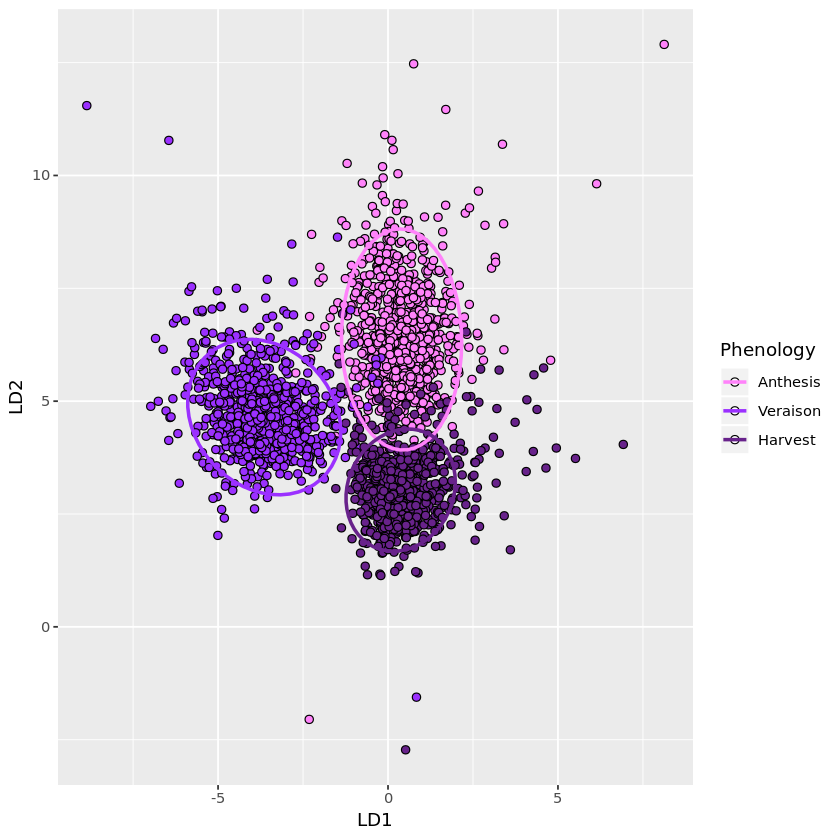

png 
  2

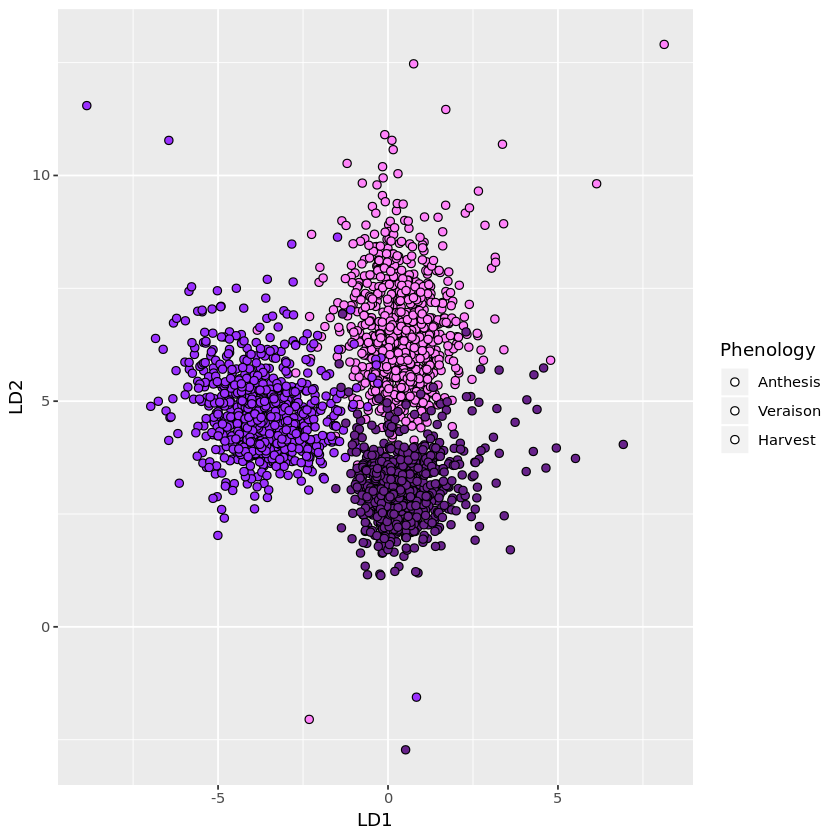

In [219]:
d <- data %>% dplyr::select(B:Cd)
y <- data$time_point
lda <- lda(d,y)
lda.scale <- data.frame(lda$scaling)

lda.plot <- data.frame(LD1=apply(d, 1, dot, y=lda.scale$LD1), LD2=apply(d, 1, dot, y=lda.scale$LD2))
lda.plot$Phenology <- data$time_point
#lda.plot$Phenology <- factor(lda.plot$Phenology, levels=c('anthesis_80', 'veraison', 'harvest'))

p <- ggplot(lda.plot, aes(x=LD1, y=LD2, fill=Phenology, shape=Phenology)) + 
  geom_point(size=2) + 
  scale_shape_manual(values=rep(21, 4)) + 
  stat_ellipse(aes(color=Phenology), linetype=1, size=1) + 
  scale_fill_manual(values=c('orchid1', 'purple1', 'darkorchid4'), labels=c('Anthesis', 'Veraison', 'Harvest')) +  
  scale_color_manual(name="Phenology", values=c('orchid1', 'purple1', 'darkorchid4'), labels=c('Anthesis', 'Veraison', 'Harvest')) + 
  guides(fill = guide_legend(override.aes = list(shape = 21)), shape = guide_legend(override.aes = list(fill = "white")))

p

pdf('2017_ionomics_LDA_phenology.pdf')
  p
dev.off()

p <- ggplot(lda.plot, aes(x=LD1, y=LD2, fill=Phenology, shape=Phenology)) + 
  geom_point(size=2) + 
  scale_shape_manual(values=rep(21, 4)) + 
  #stat_ellipse(aes(color=Phenology), linetype=1, size=1) + 
  scale_fill_manual(name='Phenology', values=c('orchid1', 'purple1', 'darkorchid4'), labels=c('Anthesis', 'Veraison', 'Harvest')) +  
  scale_color_manual(name='Phenology', values=c('orchid1', 'purple1', 'darkorchid4'), labels=c('Anthesis', 'Veraison', 'Harvest')) + 
  guides(fill = guide_legend(override.aes = list(shape = 21)), shape = guide_legend(override.aes = list(fill = "white")))

p

pdf('2017_ionomics_LDA_phenology_noEllipses.pdf')
  p
dev.off()

png 
  2

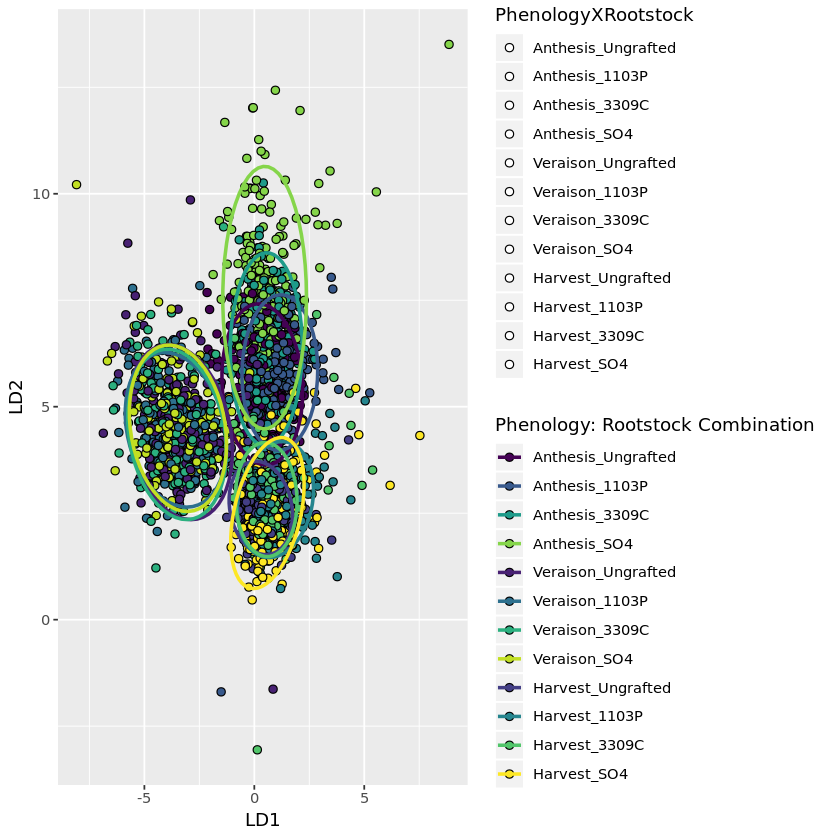

png 
  2

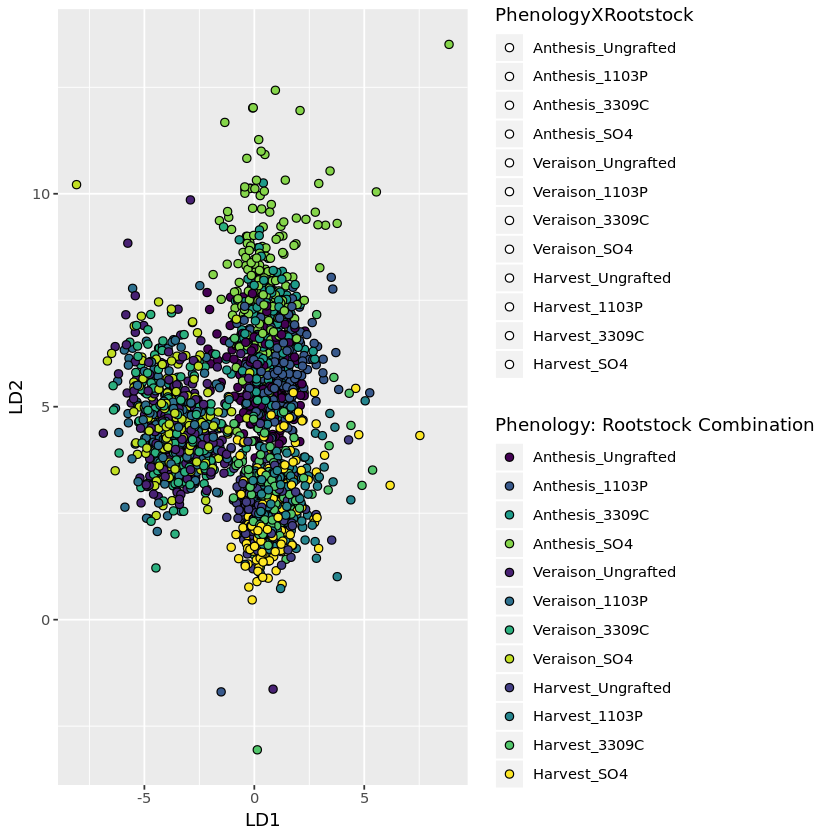

In [220]:
d <- data %>% dplyr::select(B:Cd)
y <- paste(data$time_point, data$rootstock, sep='_')
lda <- lda(d,y)
lda.scale <- data.frame(lda$scaling)

lda.plot <- data.frame(LD1=apply(d, 1, dot, y=lda.scale$LD1), LD2=apply(d, 1, dot, y=lda.scale$LD2))
lda.plot$PhenologyXRootstock <- y
lda.plot$PhenologyXRootstock <- factor(lda.plot$PhenologyXRootstock, levels=c('Anthesis_Ungrafted', 'Anthesis_1103P', 'Anthesis_3309C', 'Anthesis_SO4',
                                                                              'Veraison_Ungrafted', 'Veraison_1103P', 'Veraison_3309C', 'Veraison_SO4', 
                                                                              'Harvest_Ungrafted', 'Harvest_1103P', 'Harvest_3309C', 'Harvest_SO4'))

viridis_contrast <- viridis(12, option='viridis')[c(1, 4, 7, 10, 2, 5, 8, 11, 3, 6, 9, 12)]
#sample(viridis(12, option='viridis'), 12)


p <- ggplot(lda.plot, aes(x=LD1, y=LD2, fill=PhenologyXRootstock, shape=PhenologyXRootstock)) + 
     geom_point(size=2) + 
     scale_shape_manual(values=rep(21, 12)) + 
     stat_ellipse(aes(color=PhenologyXRootstock), linetype=1, size=1) + 
     scale_fill_manual(name="Phenology: Rootstock Combination", values=viridis_contrast, labels = c('Anthesis_Ungrafted', 'Anthesis_1103P', 'Anthesis_3309C', 'Anthesis_SO4',
                                                                                                    'Veraison_Ungrafted', 'Veraison_1103P', 'Veraison_3309C', 'Veraison_SO4', 
                                                                                                    'Harvest_Ungrafted', 'Harvest_1103P', 'Harvest_3309C', 'Harvest_SO4')) +
     scale_color_manual(name="Phenology: Rootstock Combination", values=viridis_contrast, labels = c('Anthesis_Ungrafted', 'Anthesis_1103P', 'Anthesis_3309C', 'Anthesis_SO4',
                                                                                                     'Veraison_Ungrafted', 'Veraison_1103P', 'Veraison_3309C', 'Veraison_SO4', 
                                                                                                     'Harvest_Ungrafted', 'Harvest_1103P', 'Harvest_3309C', 'Harvest_SO4')) +
     guides(fill = guide_legend(override.aes = list(shape = 21)), shape = guide_legend(override.aes = list(fill = "white")))

p

pdf('2017_ionomics_LDA_phenologyRootstock.pdf')
  p
dev.off()

p <- ggplot(lda.plot, aes(x=LD1, y=LD2, fill=PhenologyXRootstock, shape=PhenologyXRootstock)) + 
     geom_point(size=2) + 
     scale_shape_manual(values=rep(21, 12)) + 
     #stat_ellipse(aes(color=PhenologyXRootstock), linetype=1, size=1) + 
     scale_fill_manual(name="Phenology: Rootstock Combination", values=viridis_contrast, labels = c('Anthesis_Ungrafted', 'Anthesis_1103P', 'Anthesis_3309C', 'Anthesis_SO4',
                                                                                                    'Veraison_Ungrafted', 'Veraison_1103P', 'Veraison_3309C', 'Veraison_SO4', 
                                                                                                    'Harvest_Ungrafted', 'Harvest_1103P', 'Harvest_3309C', 'Harvest_SO4')) +
     scale_color_manual(name="Phenology: Rootstock Combination", values=viridis_contrast, labels = c('Anthesis_Ungrafted', 'Anthesis_1103P', 'Anthesis_3309C', 'Anthesis_SO4',
                                                                                                    'Veraison_Ungrafted', 'Veraison_1103P', 'Veraison_3309C', 'Veraison_SO4', 
                                                                                                    'Harvest_Ungrafted', 'Harvest_1103P', 'Harvest_3309C', 'Harvest_SO4')) +
     guides(fill = guide_legend(override.aes = list(shape = 21)), shape = guide_legend(override.aes = list(fill = "white")))

p

pdf('2017_ionomics_LDA_phenologyRootstock_noEllipses.pdf')
  p
dev.off()


## Main Figures

Here, I put together some sections of the main ionomics figure for future mashing together in Inkscape. 

In [22]:
# pdf('2017_ionomics_corrplot.pdf', width=12, height=12)
#   corrplot(ionFig1a, type = "upper", order = "hclust", tl.col = "black", tl.srt = 45, col=rev(viridis(100)))
#   t
# dev.off()

png 
  2

In [221]:
pdf('2017_ionomics_main_confMat.pdf', width=12, height=4)
  ggpubr::ggarrange(ionFig1a, ionFig1b, ionFig1c, labels=c('D', 'E', 'F'), ncol=3, common.legend=T, legend='right')
dev.off()

png 
  2

In [222]:
rs_c_pal <- c("gray","#1b9e77", "#7570b3", "#e6ab02")
leaf_c_pal <- c(rgb(145,102,189,maxColorValue=255),rgb(178,76,76,maxColorValue=255),rgb(0,146,146,maxColorValue=255),rgb(255,182,119,maxColorValue=255))

In [67]:
vars <- c('B', 'P', 'Ni', 'Mg', 'Mo', 'S', 'Sr')
rs_plots <- list(rep(0, length(vars)))

for (idx in 1:length(vars)){ 
    # get element name at index
    element_id <- vars[idx]
    
    #extract data
    d <- data[,c('sample', 'row', 'irrigation', 'leaf', 'rootstock', 'time_point', 'block')]
    d$element <- data[,element_id]
    d_norm <- as.vector(scale(d$element, scale=TRUE, center=TRUE))
    d$element <- d_norm
    
    # remove outliers, fix colnames
    d <- anomalize(as_tibble(d), target=element, method='iqr', alpha=0.03, max_anoms=0.1)
    d <- d[d$anomaly != 'Yes',]
    colnames(d) <- c('sample', 'Row', 'Irrigation', 'Leaf_index', 'Rootstock', 'Phenology', 'Block', 'element', 'e1', 'e2', 'anomaly')
        
    p <- ggplot(d, aes(x=Rootstock, y=element, fill=Rootstock)) + 
         geom_boxplot() +
         ylab(element_id) + 
         scale_fill_manual(name='Rootstock', values=rs_c_pal) +
         facet_wrap('Phenology') + 
         theme(panel.grid.major.x = element_blank(), panel.grid.minor.y = element_blank()) + theme_bw() + theme(axis.text.x = element_text(angle = 90, hjust = 1))
    rs_plots[[idx]] <- p
    #print(p)
}

In [74]:
vars <- c('Rb', 'Mn', 'Al', 'Ca', 'K', 'Na')
lp_plots <- list(rep(0, length(vars)))

for (idx in 1:length(vars)){ 
    # get element name at index
    element_id <- vars[idx]
    
    #extract data
    d <- data[,c('sample', 'row', 'irrigation', 'leaf', 'rootstock', 'time_point', 'block')]
    d$element <- data[,element_id]
    d_norm <- as.vector(scale(d$element, scale=TRUE, center=TRUE))
    d$element <- d_norm
    
    # remove outliers, fix colnames
    d <- anomalize(as_tibble(d), target=element, method='iqr', alpha=0.05, max_anoms=0.1)
    d <- d[d$anomaly != 'Yes',]
    colnames(d) <- c('sample', 'Row', 'Irrigation', 'Leaf_index', 'Rootstock', 'Phenology', 'Block', 'element', 'e1', 'e2', 'anomaly')
    
    p <- ggplot(d, aes(x=Leaf_index, y=element, fill=Leaf_index)) + 
         geom_boxplot() +
         ylab(element_id) + 
         scale_fill_manual(name='Leaf_index', values=leaf_c_pal) +
         scale_x_discrete(labels=c(1,2,3)) + 
         facet_wrap('Phenology') + 
         theme(panel.grid.major.x = element_blank(), panel.grid.minor.y = element_blank()) + theme_bw()
    lp_plots[[idx]] <- p
}

In [78]:
pdf('2017_ionomics_main_rsP.pdf', width=8, height=4)
  ggpubr::ggarrange(rs_plots[[3]], rs_plots[[5]], ncol=2, common.legend=TRUE, legend='none')
dev.off()

pdf 
  2

In [79]:
pdf('2017_ionomics_main_lpP.pdf', width=8, height=4)
  ggpubr::ggarrange(lp_plots[[4]], lp_plots[[5]], ncol=2, common.legend=TRUE, legend='none')
dev.off()

pdf 
  2